In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
%matplotlib inline
%config InlineBackend.figure_format ='retina'

COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']
# See https://matplotlib.org/3.5.0/_images/sphx_glr_colormaps_006_2_0x.png

from simulation import *
from statsmodels.stats.proportion import proportion_confint

import pickle

def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="A worker stopped while some jobs were given to the executor",
    category=UserWarning
)

In [7]:
import os
from tqdm import tqdm

plist = np.arange(0.18, 0.231, 0.01).round(decimals=6)
dlist = [11, 13, 15, 17, 19]
target_n_samples = 100_000_000

max_n_samples_per_batch = 1000000
n_jobs = 19

dirc = 'data/surface_code_bitflip_lsd0_omc'
os.makedirs(dirc, exist_ok=True)

for d in dlist:
    for p in plist:
        print(f'd={d}, p={p}')
        path = os.path.join(dirc, f'd{d}_p{p}.pkl')
        try:
            data = read_pickle(path)
            d_saved, p_saved, df = data['d'], data['p'], data['df']
            for col in df.columns:
                df[col] = df[col].astype('uint64')
            assert d == d_saved and p == p_saved
        except FileNotFoundError:
            df = None

        circuit = build_circuit_surface_code(d, 1, p_bitflip=p)

        while True:
            if df is None:
                curr_n_samples = 0
            else:
                try:
                    curr_n_samples = df['num_samples_cf'].sum()
                except KeyError:
                    curr_n_samples = 0
            left_n_samples = target_n_samples - curr_n_samples
            if left_n_samples <= 0:
                break

            n_samples_batch = min(left_n_samples, max_n_samples_per_batch)
            df_partial = simulate(circuit,
                                  n_samples_batch,
                                  lsd_order=0,
                                  n_jobs=n_jobs,
                                  n_batch=n_jobs * 5,
                                  get_aggr_data=True,
                                  get_logical_gaps=False,
                                  Q_digits=2,
                                  d=d,
                                  p=p,
                                  verbose=0)
            if df is None:
                df = df_partial
            else:
                df = pd.concat([df, df_partial], axis=0).groupby(level=0).sum()

            data = {'d': d, 'p': p, 'df': df}
            write_pickle(path, data)

d=11, p=0.18
d=11, p=0.19
d=11, p=0.2
d=11, p=0.21
d=11, p=0.22
d=11, p=0.23
d=13, p=0.18
d=13, p=0.19
d=13, p=0.2
d=13, p=0.21
d=13, p=0.22
d=13, p=0.23
d=15, p=0.18
d=15, p=0.19
d=15, p=0.2
d=15, p=0.21
d=15, p=0.22
d=15, p=0.23
d=17, p=0.18
d=17, p=0.19
d=17, p=0.2
d=17, p=0.21
d=17, p=0.22
d=17, p=0.23
d=19, p=0.18
d=19, p=0.19
d=19, p=0.2
d=19, p=0.21
d=19, p=0.22
d=19, p=0.23


In [ ]:
import os
from tqdm import tqdm

target_n_samples = {
#     (0.92, 11, 0.21): 310893244,
#     (0.92, 11, 0.22): 723040892,
#     (0.92, 11, 0.23): 1607805377,
#     (0.92, 13, 0.18): 112292186,
#     (0.92, 13, 0.19): 387559927,
#     (0.92, 13, 0.2): 1158739814,
#     (0.92, 13, 0.21): 3752400480,
#     (0.92, 13, 0.22): 12280632406,
#     (0.92, 13, 0.23): 43237959584,
#     (0.92, 15, 0.18): 1613995195,
#     (0.92, 15, 0.19): 6228295763,
#     (0.92, 15, 0.2): 37092404443,
#     (0.92, 15, 0.21): 183940169741,
    (0.92, 17, 0.18): 24990683134
}
max_n_samples_per_batch = 1000000
n_jobs = 19

prms_list = [k for k, v in sorted(target_n_samples.items(), key=lambda item: item[1])]
target_n_samples_list = [v for k, v in sorted(target_n_samples.items(), key=lambda item: item[1])]

dirc = 'data/surface_code_bitflip_lsd0_omc'
os.makedirs(dirc, exist_ok=True)

for (_, d, p), target_n_samples_curr in zip(prms_list, target_n_samples_list):
    print(f'd={d}, p={p}')
    path = os.path.join(dirc, f'd{d}_p{p}.pkl')
    try:
        data = read_pickle(path)
        d_saved, p_saved, df = data['d'], data['p'], data['df']
        for col in df.columns:
            df[col] = df[col].astype('uint64')
        assert d == d_saved and p == p_saved
    except FileNotFoundError:
        df = None

    circuit = build_circuit_surface_code(d, 1, p_bitflip=p)

    while True:
        try:
            curr_n_samples = df['num_samples_cf'].sum()
        except KeyError:
            curr_n_samples = 0
        left_n_samples = target_n_samples_curr - curr_n_samples
        if left_n_samples <= 0:
            break

        n_samples_batch = min(left_n_samples, max_n_samples_per_batch)
        df_partial = simulate(circuit,
                              n_samples_batch,
                              lsd_order=0,
                              n_jobs=n_jobs,
                              n_batch=n_jobs * 5,
                              get_aggr_data=True,
                              get_logical_gaps=False,
                              Q_digits=2,
                              d=d,
                              p=p,
                              verbose=0)
        if df is None:
            df = df_partial
        else:
            df = pd.concat([df, df_partial], axis=0).groupby(level=0).sum()

        data = {'d': d, 'p': p, 'df': df}
        write_pickle(path, data)

d=17, p=0.18


# Cluster frac vs. detector density

<Axes: xlabel='cluster_frac', ylabel='det_density'>

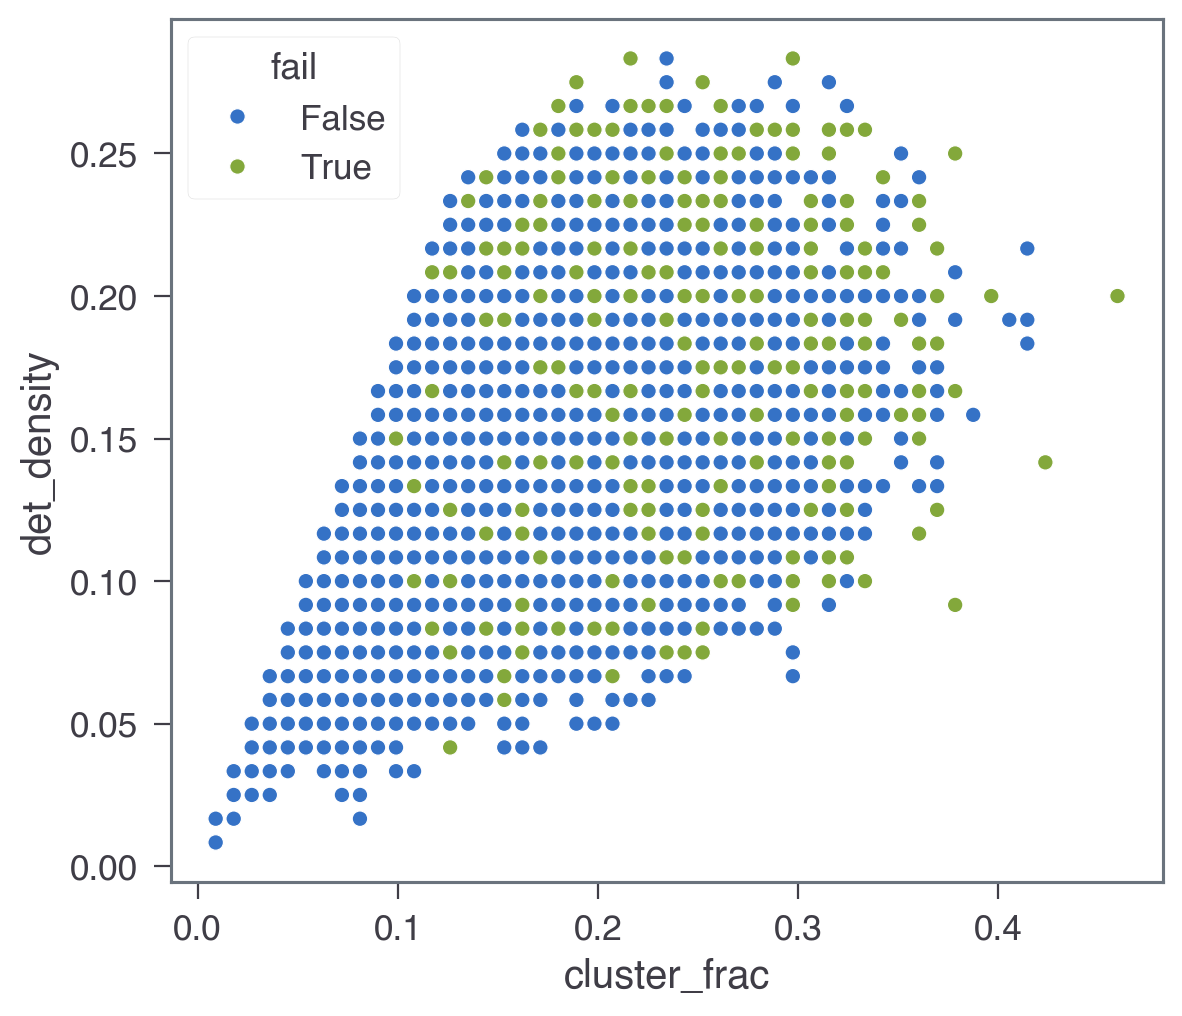

In [143]:
import seaborn as sns
df = read_df(11, 0.1).iloc[:100_000, :]
sns.scatterplot(df, x='cluster_frac', y='det_density', hue='fail')

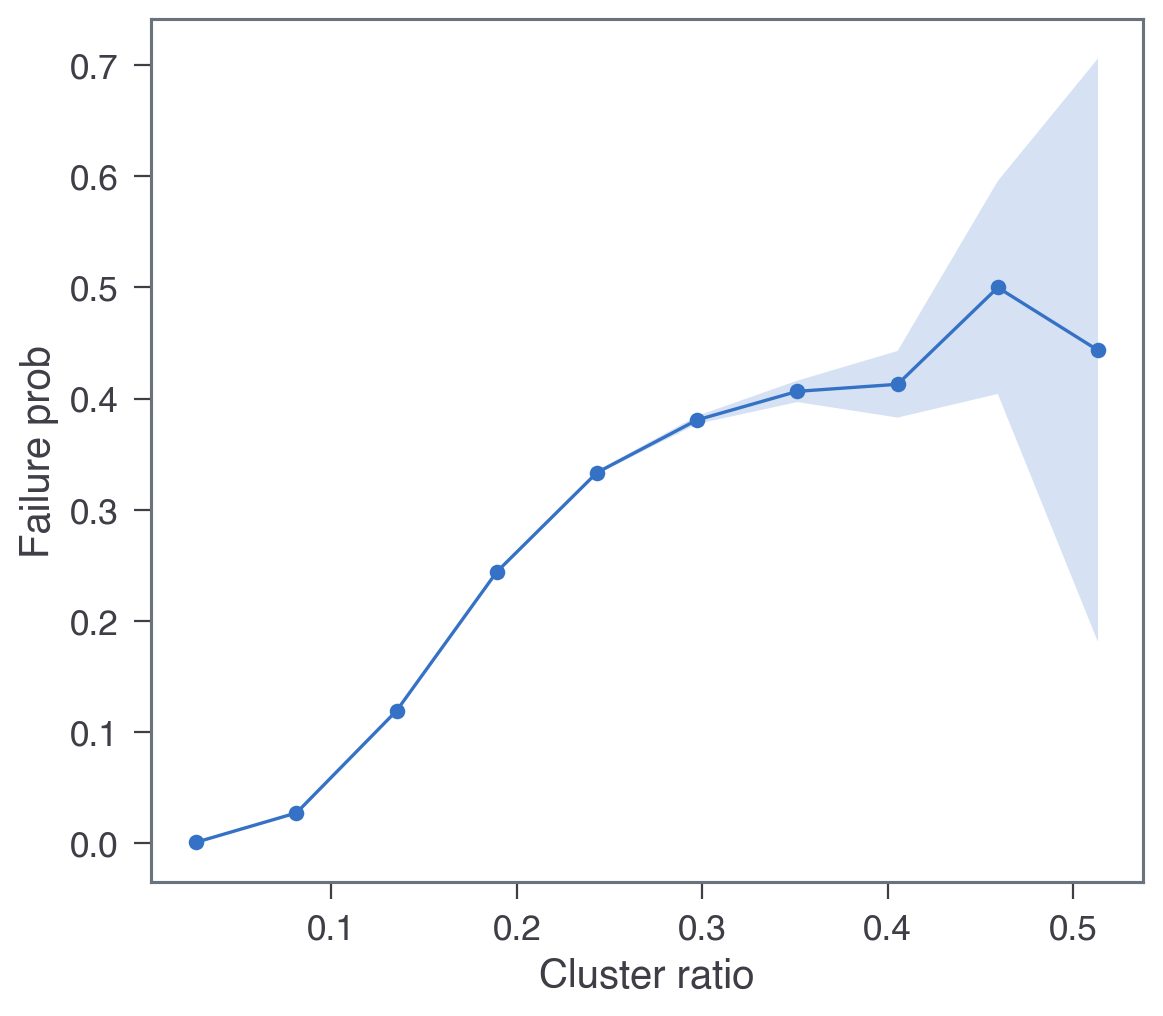

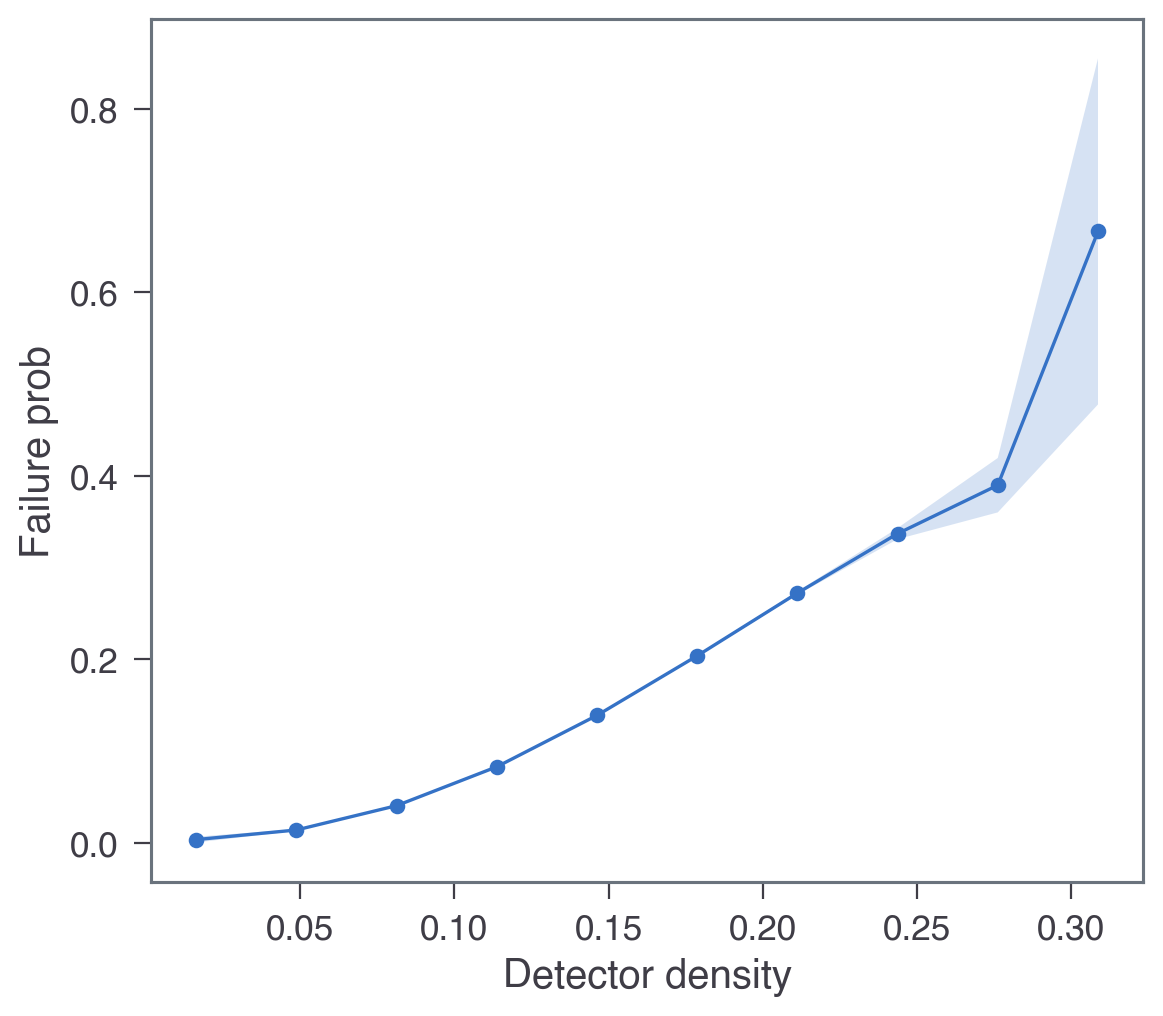

In [49]:
df = read_df(11, 0.1)

cf = df['cluster_frac']
dd = df['det_density']

xs = np.linspace(min(cf), max(cf), 11)
pfails = []
pfails_low = []
pfails_upp = []
for i_x in range(len(xs) - 1):
    df_partial = df[(cf >= xs[i_x]) & (cf < xs[i_x + 1])]
    pfail_low, pfail_upp = proportion_confint(df_partial['fail'].sum(),
                                              len(df_partial),
                                              alpha=0.05,
                                              method='binom_test')
    pfail = (pfail_low + pfail_upp) / 2
    pfails.append(pfail)
    pfails_low.append(pfail_low)
    pfails_upp.append(pfail_upp)

xs_mid = (xs[:-1] + xs[1:])/2
plt.plot(xs_mid, pfails, 'o-')
plt.fill_between(xs_mid, pfails_low, pfails_upp, alpha=.2)
plt.xlabel('Cluster frac')
plt.ylabel('Failure prob')
plt.show()

xs = np.linspace(min(dd), max(dd), 11)
pfails = []
pfails_low = []
pfails_upp = []
for i_x in range(len(xs) - 1):
    df_partial = df[(dd >= xs[i_x]) & (dd < xs[i_x + 1])]
    pfail_low, pfail_upp = proportion_confint(df_partial['fail'].sum(),
                                              len(df_partial),
                                              alpha=0.05,
                                              method='binom_test')
    pfail = (pfail_low + pfail_upp) / 2
    pfails.append(pfail)
    pfails_low.append(pfail_low)
    pfails_upp.append(pfail_upp)

xs_mid = (xs[:-1] + xs[1:])/2
plt.plot(xs_mid, pfails, 'o-')
plt.fill_between(xs_mid, pfails_low, pfails_upp, alpha=.2)
plt.xlabel('Detector density')
plt.ylabel('Failure prob')
plt.show()

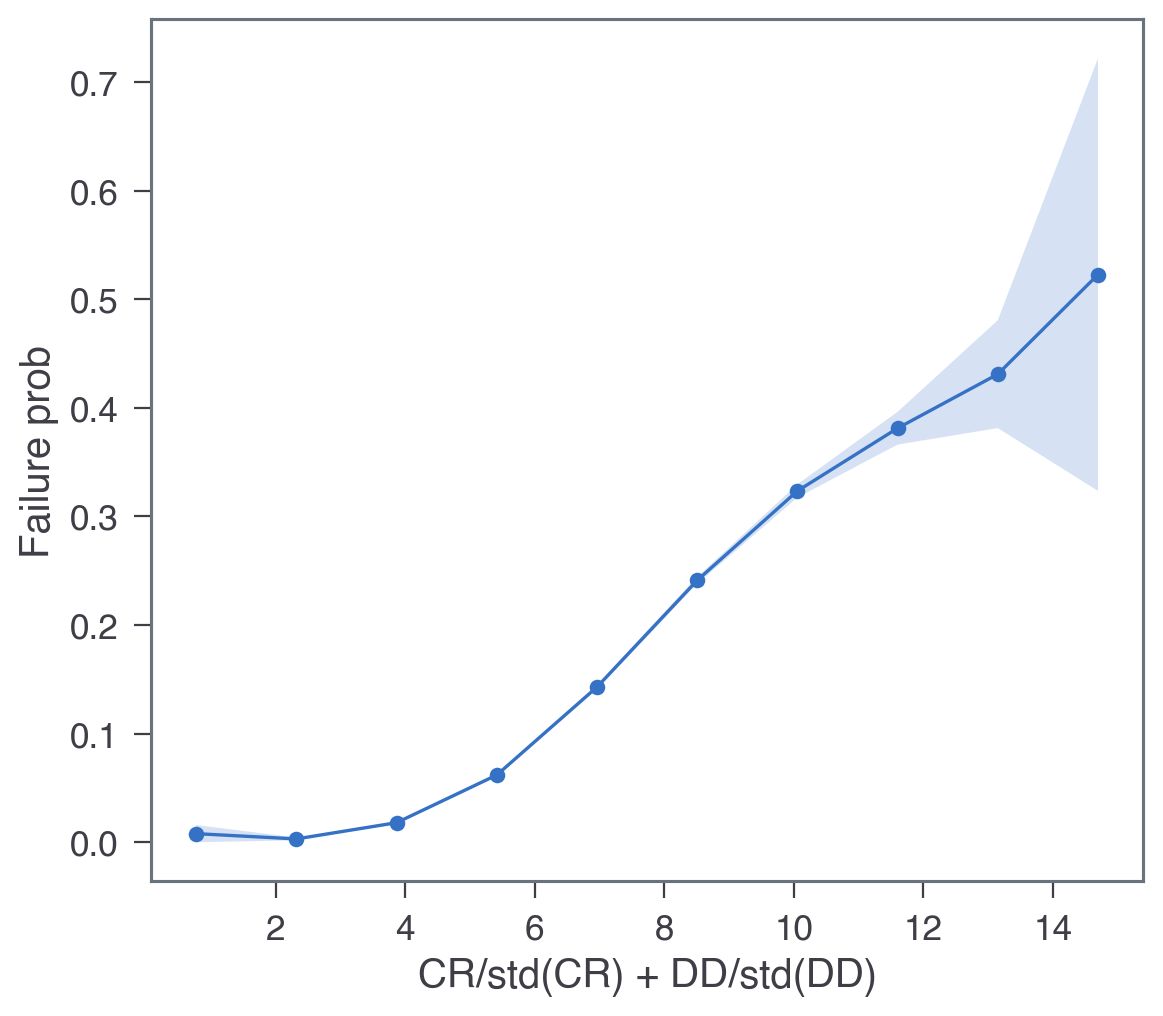

In [101]:
df = read_df(11)
df = df[(df['p'] == 0.1)]

cf = df['cluster_frac']
dd = df['det_density']
df['x'] = cf / np.std(cf) + dd / np.std(dd)

xs = np.linspace(min(df['x']), max(df['x']), 11)
pfails = []
pfails_low = []
pfails_upp = []
for i_x in range(len(xs) - 1):
    x_vals = df['x']
    df_partial = df[(x_vals >= xs[i_x]) & (x_vals < xs[i_x + 1])]
    pfail_low, pfail_upp = proportion_confint(df_partial['fail'].sum(),
                                              len(df_partial),
                                              alpha=0.05,
                                              method='binom_test')
    pfail = (pfail_low + pfail_upp) / 2
    pfails.append(pfail)
    pfails_low.append(pfail_low)
    pfails_upp.append(pfail_upp)

xs_mid = (xs[:-1] + xs[1:])/2
plt.plot(xs_mid, pfails, 'o-')
plt.fill_between(xs_mid, pfails_low, pfails_upp, alpha=.2)
plt.xlabel('cf/std(cf) + DD/std(DD)')
plt.ylabel('Failure prob')
plt.show()

In [102]:
cf = df['cluster_frac']
cf_mean, cf_std = cf.mean(), cf.std()
cf_succ_mean, cf_fail_mean = (df[df['fail']==i]['cluster_frac'].mean() for i in range(2))
print((cf_fail_mean - cf_succ_mean)/cf_std)

dd = df['det_density']
dd_mean, dd_std = dd.mean(), dd.std()
dd_succ_mean, dd_fail_mean = (df[df['fail']==i]['det_density'].mean() for i in range(2))
print((dd_fail_mean - dd_succ_mean)/dd_std)

# x = df['x']
# x_mean, x_std = x.mean(), x.std()
# x_succ_mean, x_fail_mean = (df[df['fail']==i]['x'].mean() for i in range(2))
# print((x_fail_mean - x_succ_mean)/x_std)

0.9085102079647698
0.5506221305729913
0.8178974271919812


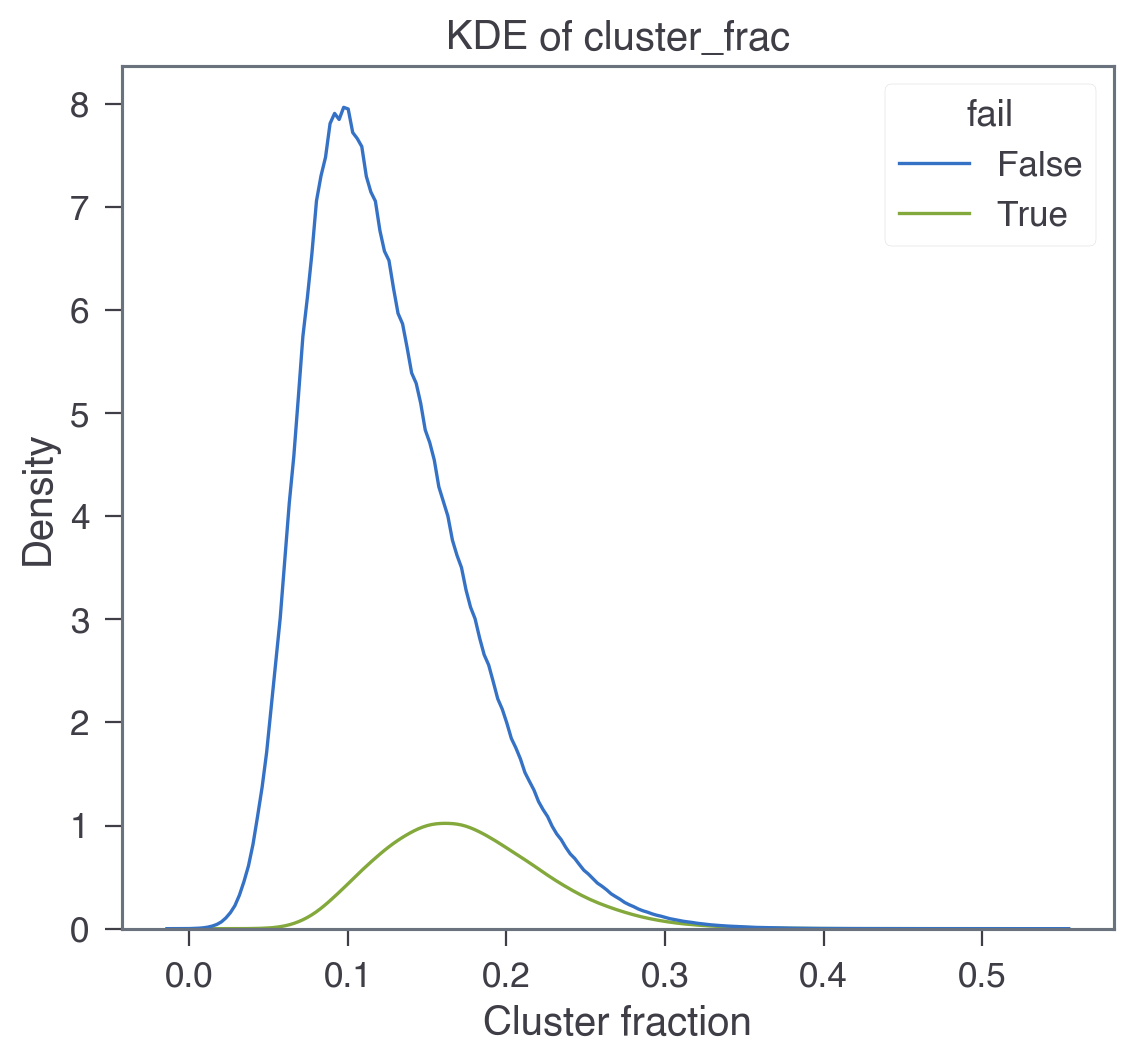

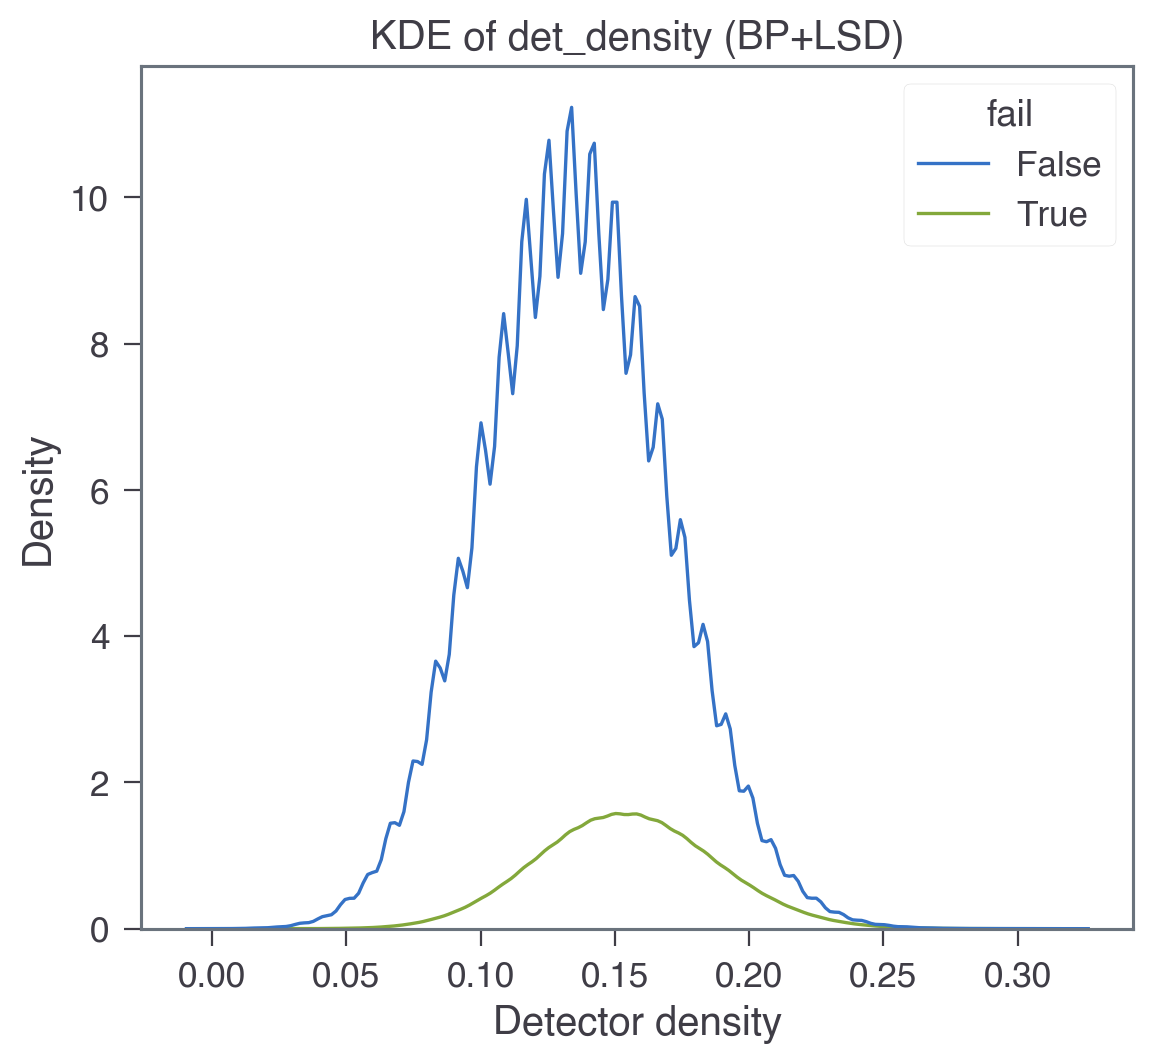

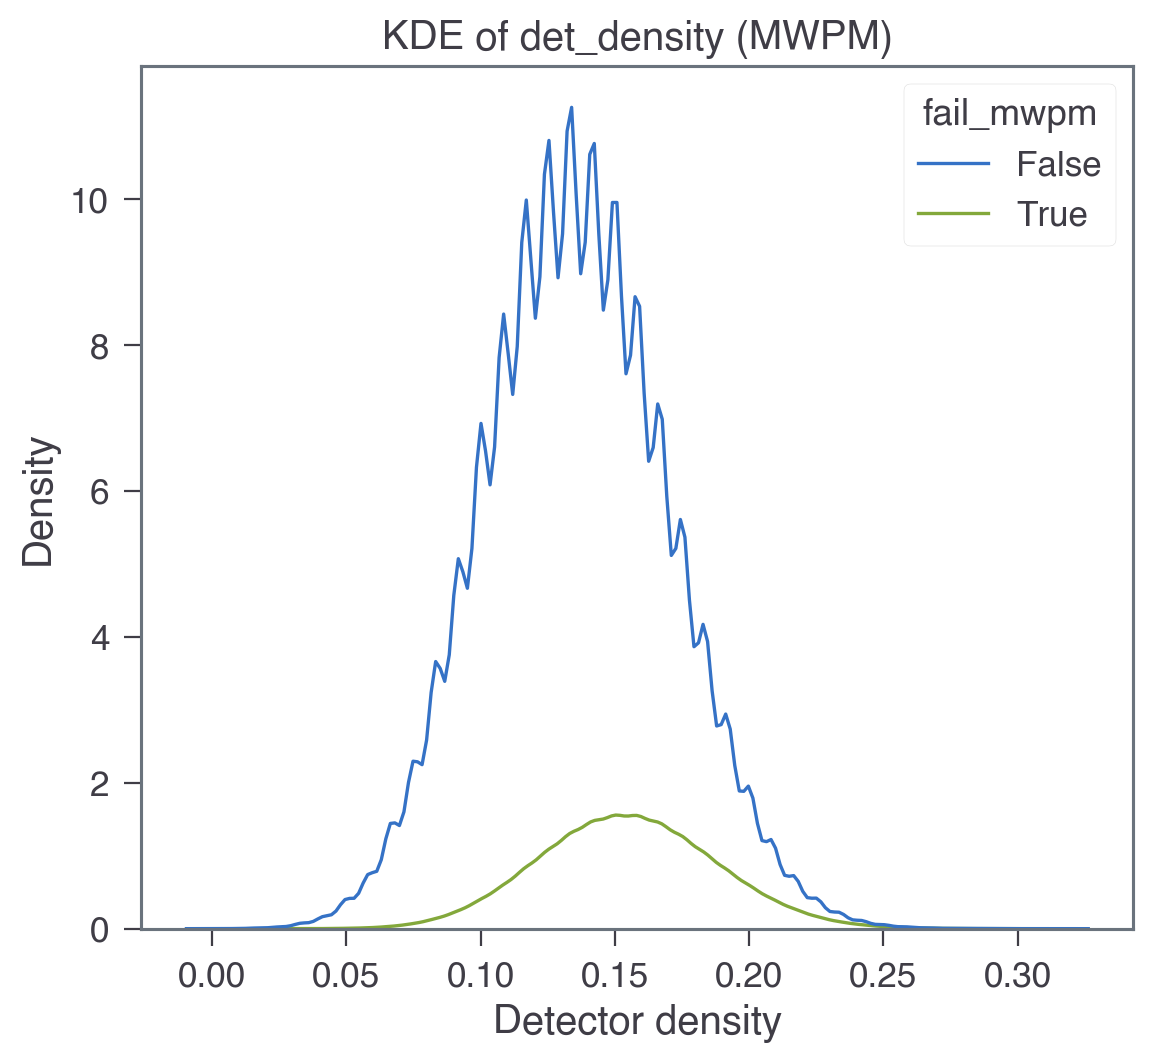

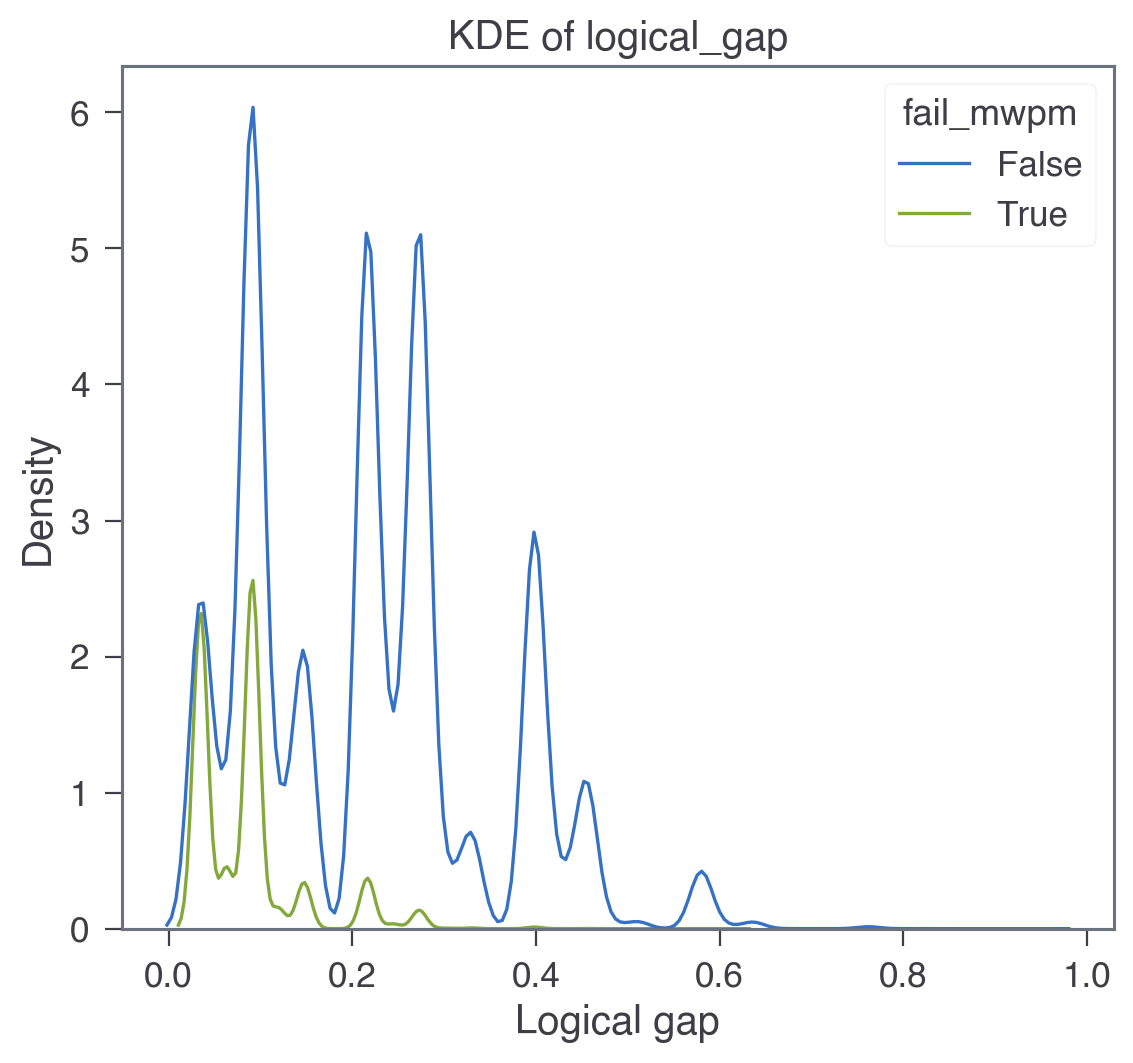

In [144]:
import seaborn as sns
from scipy.stats import iqr as compute_iqr

data = read_df(11, 0.1)

# KDE for cluster frac
sns.kdeplot(data, x='cluster_frac', hue='fail', bw_adjust=2)
plt.xlabel('Cluster fraction')
plt.title('KDE of cluster_frac')
plt.show()

# KDE for det density (BP+LSD)
sns.kdeplot(data, x='det_density', hue='fail', bw_adjust=2)
plt.xlabel('Detector density')
plt.title('KDE of det_density (BP+LSD)')
plt.show()

# KDE for det density (MWPM)
sns.kdeplot(data, x='det_density', hue='fail_mwpm', bw_adjust=2)
plt.xlabel('Detector density')
plt.title('KDE of det_density (MWPM)')
plt.show()

# KDE for det density
sns.kdeplot(data, x='logical_gap', hue='fail_mwpm', bw_adjust=2)
plt.xlabel('Logical gap')
plt.title('KDE of logical_gap')
plt.show()

# Failure & Abort rates

In [248]:
def task(d, p, clist):
    df = read_df(d, p)
    outputs = compute_ps_performance(df, clist)
    del df
    for df in outputs.values():
        df['d'] = d
        df['p'] = p
        df.reset_index(inplace=True)
        df.set_index(['d', 'p', 'c'], inplace=True)
    return outputs

In [249]:
from joblib import Parallel, delayed

clist = np.arange(0, 1.001, 0.01).round(decimals=6)
dlist = np.arange(11, 20, 2)
plist = np.arange(0.01, 0.301, 0.01).round(decimals=6)

with Parallel(n_jobs=20, verbose=1, backend='loky') as parallel:
    outputs = parallel(delayed(task)(d, p, clist) for d in dlist for p in plist)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   44.1s
/Users/slee7208/.pyenv/versions/3.11.3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/slee7208/.pyenv/versions/3.11.3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/slee7208/.pyenv/versions/3.11.3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/slee7208/.pyenv/versions/3

In [250]:
strat_dict = {'det_density': 0, 'cluster_frac': 1, 'logical_gap': 2}
df_ps = pd.DataFrame()
for strat in outputs[0].keys():
    df = pd.concat([output[strat] for output in outputs], axis=0)
    df.sort_index(inplace=True)
    df['strategy'] = strat
    df_ps = pd.concat([df_ps, df])
df_ps = df_ps.reset_index().set_index(['strategy', 'c', 'd', 'p']).sort_index()

In [251]:
df_ps

fail    delta_fail         abort   delta_abort
strategy     c    d  p                                                       
cluster_frac 0.00 11 0.01  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
                     0.02  0.000054  6.451637e-06  3.898173e-07  3.898173e-07
                     0.03  0.000532  2.025045e-05  3.898173e-07  3.898173e-07
                     0.04  0.002374  4.273100e-05  3.898173e-07  3.898173e-07
                     0.05  0.007336  7.485010e-05  3.898173e-07  3.898173e-07
...                             ...           ...           ...           ...
logical_gap  0.97 19 0.03  0.019973  1.997314e-02  9.999808e-01  3.925953e-06
                     0.04  0.250000  2.500000e-01  9.999986e-01  9.960660e-07
             0.98 17 0.01  0.000007  7.426828e-06  9.452375e-01  1.994500e-04
                  19 0.01  0.000015  1.527282e-05  9.734302e-01  1.410470e-04
                     0.02  0.000558  5.576987e-04  9.992952e-01  2.333947e-05

[38077 rows x 4 columns]

<Axes: xlabel='abort', ylabel='fail'>

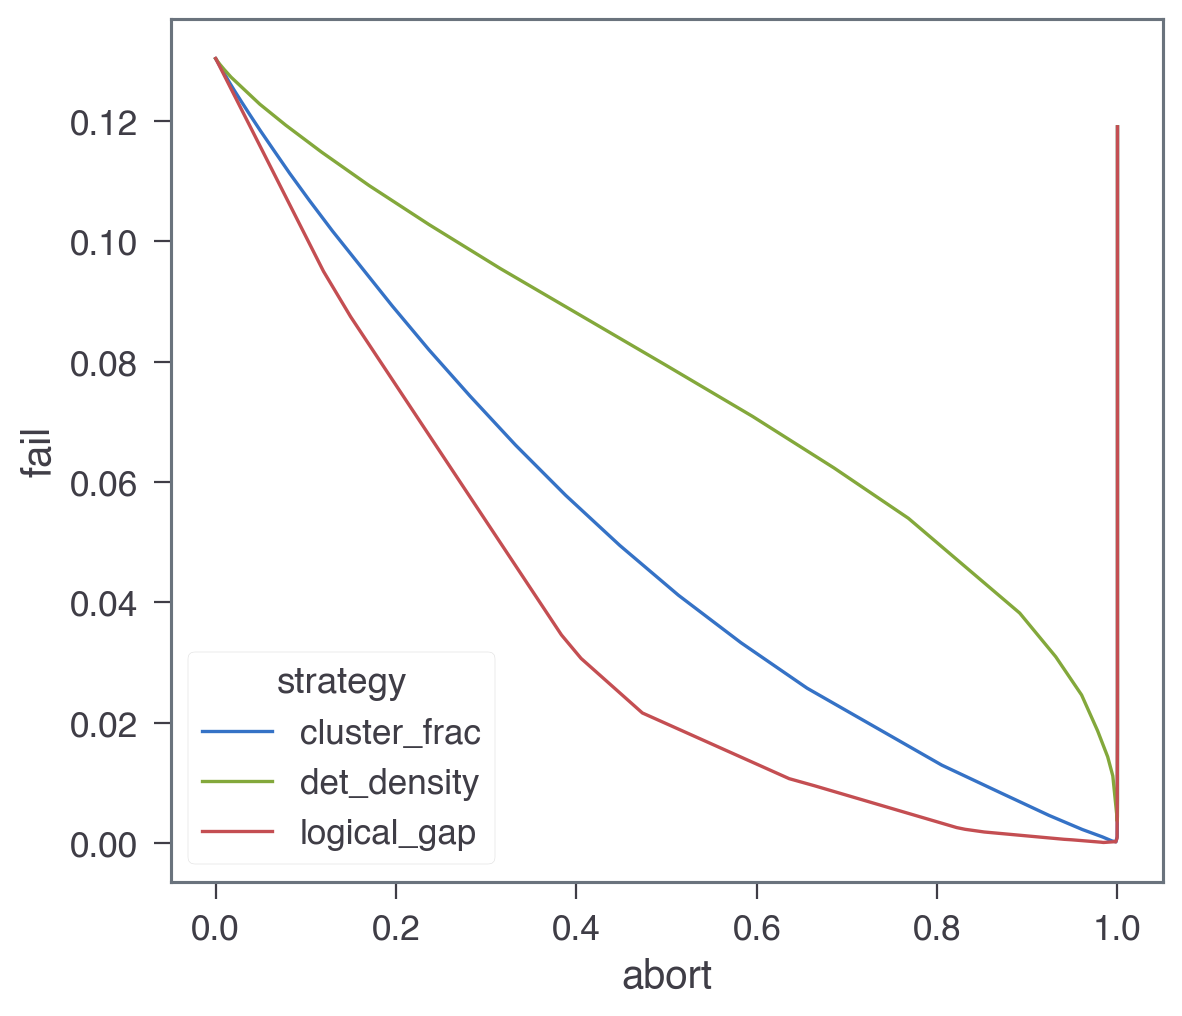

In [253]:
sns.lineplot(df_ps.loc[idx[:, :, 11, 0.1], :].reset_index(), x='abort', y='fail', hue='strategy')

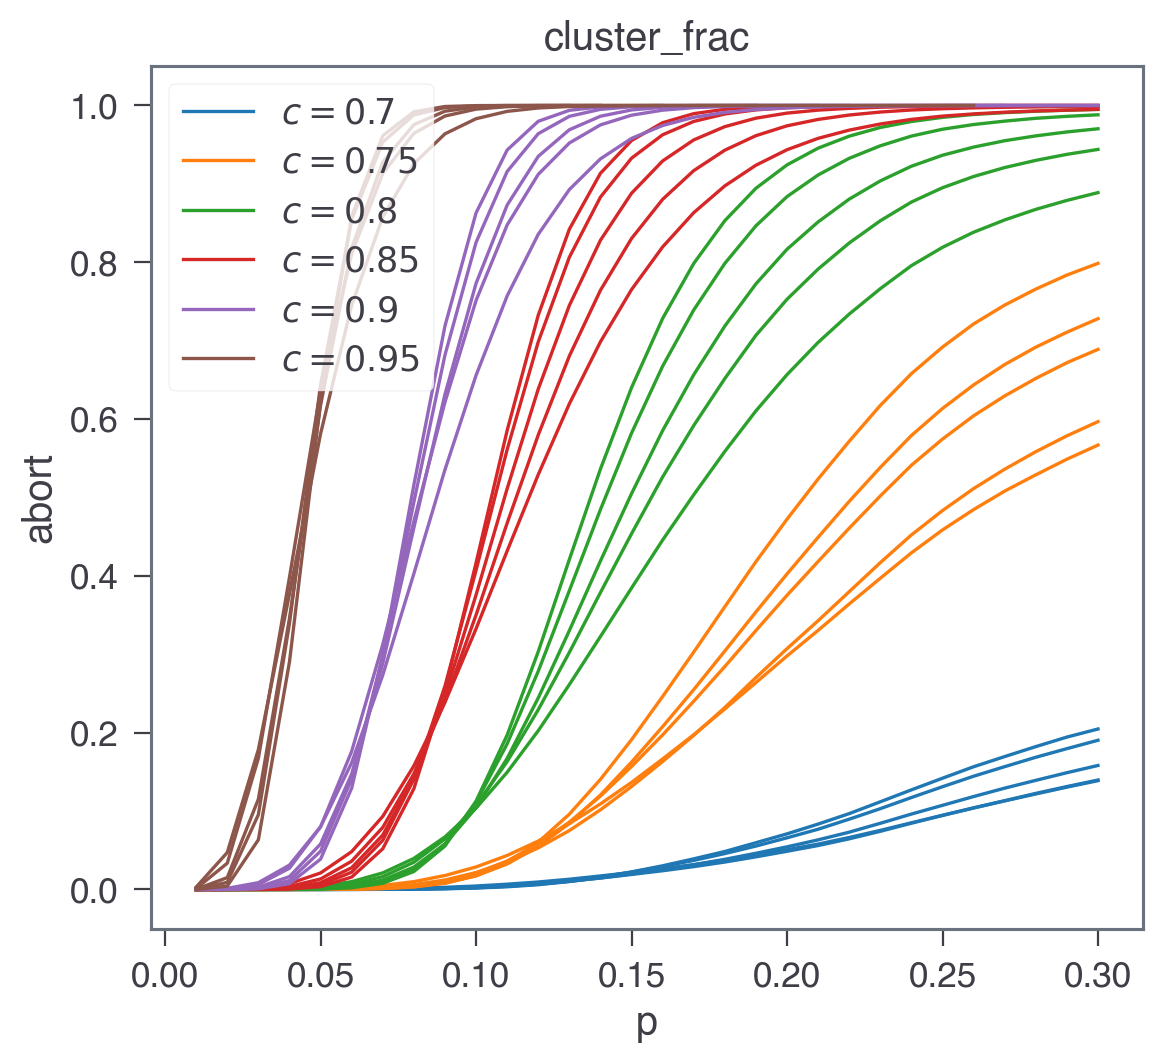

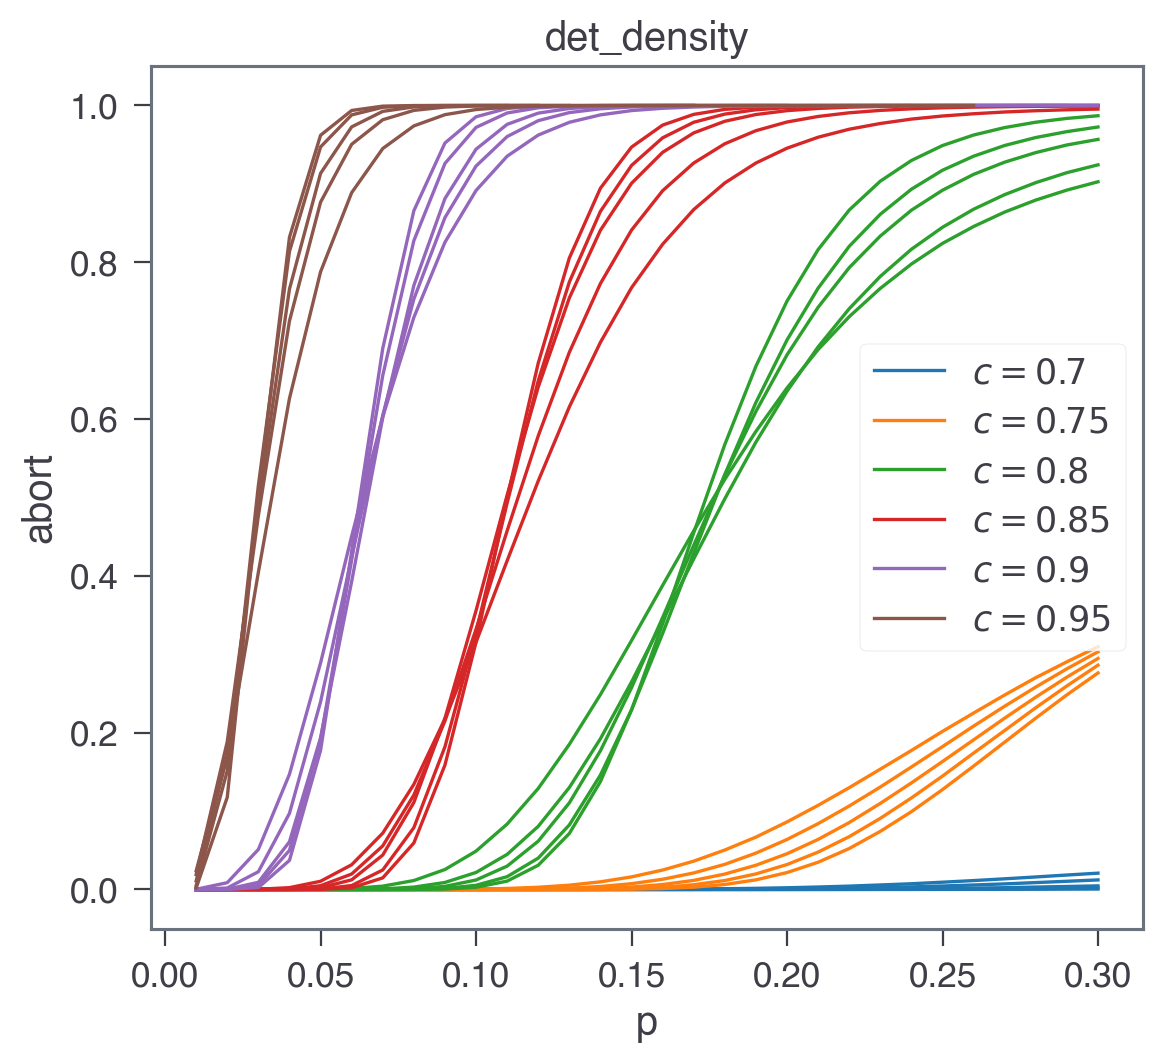

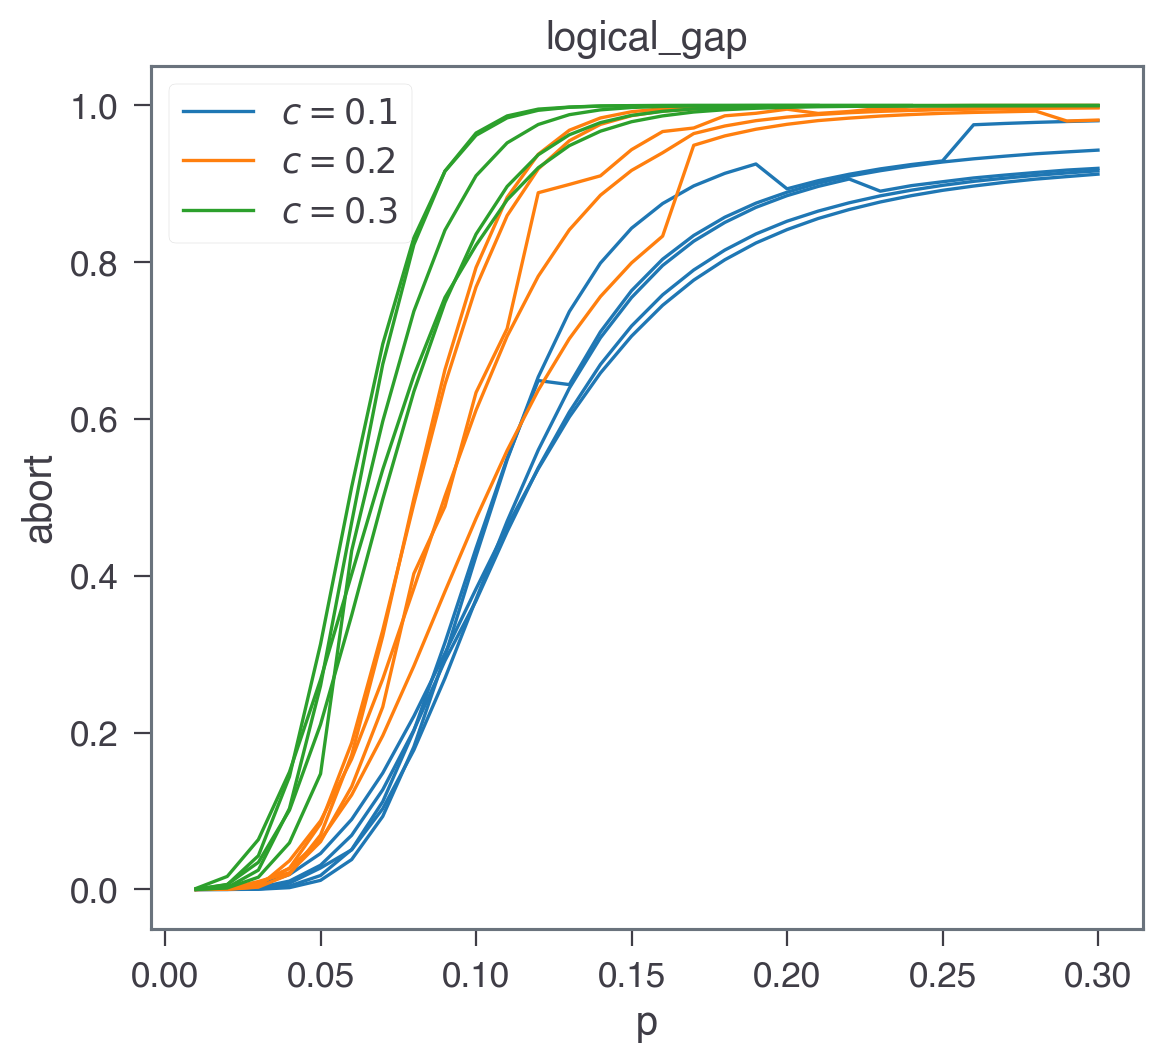

In [45]:
# cmap = plt.cm.viridis
strats = df_ps.index.get_level_values('strategy').unique()
# clist_plot = np.round(clist_plot, decimals=6)
for strat in strats:
    if strat == 'logical_gap':
        clist_plot = np.arange(0.1, 0.31, 0.1).round(decimals=6)
    else:
        clist_plot = np.arange(0.7, 0.96, 0.05).round(decimals=6)
    for i_c, c in enumerate(clist_plot):
        color = COLORS(i_c)
        for i_d, d in enumerate(dlist):
            label = r'$c={}$'.format(c) if i_d == 0 else None
            plot_error_band(df_ps.loc[idx[d, :, strat, c], :].reset_index(),
                            x='p', y='abort', delta_y='delta_abort', 
                            color=color, label=label)
    plt.title(strat)
    plt.show()

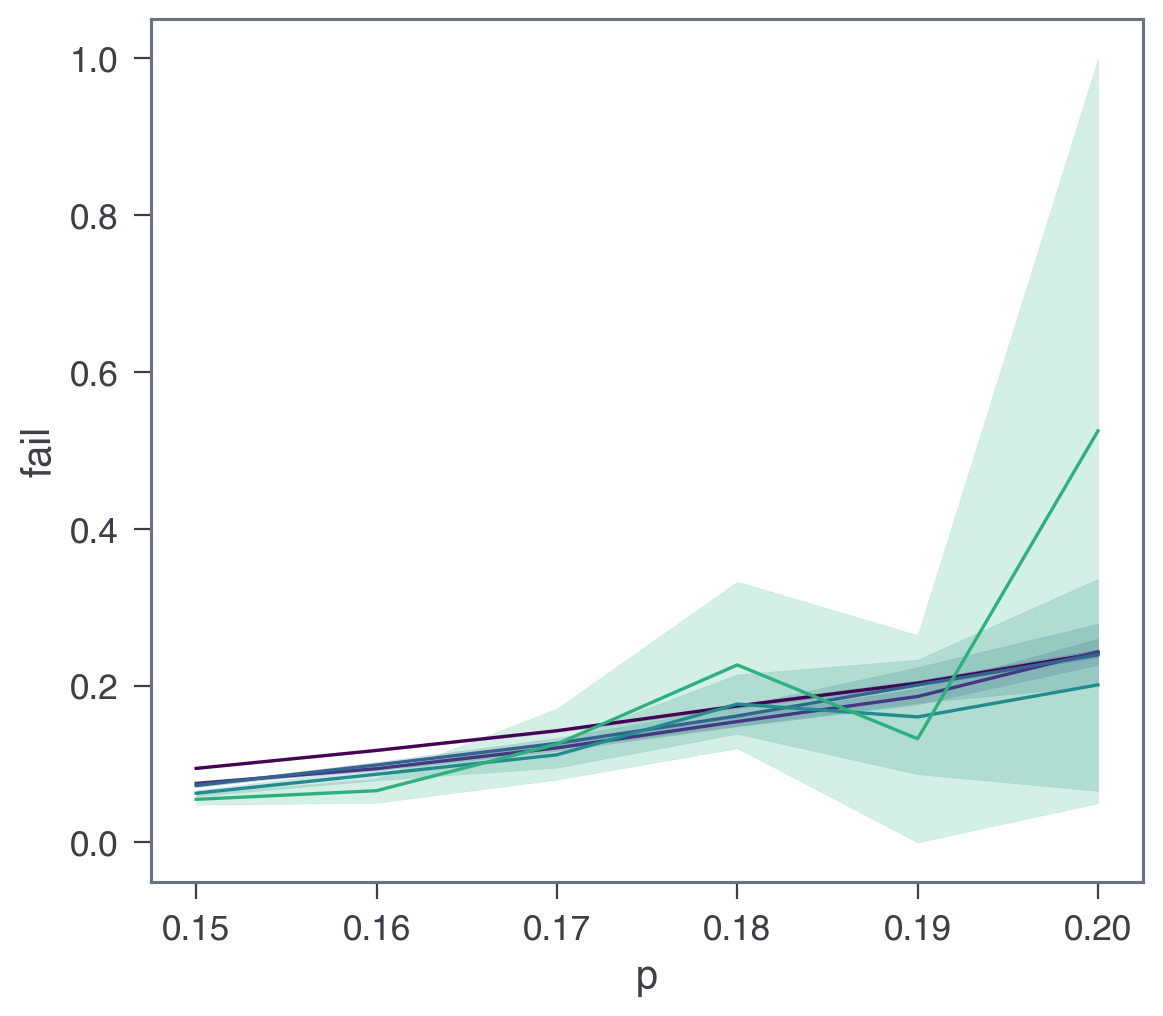

In [258]:
df_ps = pd.read_pickle('data/surface_code_bitflip_lsd0_ps')
cmap = plt.cm.viridis
clist_plot = [0.9]
dlist = np.arange(11, 20, 2)
# clist_plot = np.round(clist_plot, decimals=6)
for i_d, d in enumerate(dlist):
    color = cmap(i_d/len(dlist)*0.8)
    for c in clist_plot:
        plot_error_band(data=df_ps.loc[idx['cluster_frac', c, d, 0.15:0.2], :].reset_index(),
                        x='p', y='fail', delta_y='delta_fail', color=color)

In [257]:
df_ps.loc[idx['cluster_frac', 0.9, :, 0.2], :]

fail  delta_fail     abort   delta_abort
strategy     c   d  p                                                
cluster_frac 0.9 11 0.2  0.241275    0.004869  0.997022  3.381327e-05
                 13 0.2  0.243295    0.016592  0.999738  1.004991e-05
                 15 0.2  0.239377    0.039591  0.999954  4.199801e-06
                 17 0.2  0.201041    0.135260  0.999997  1.124569e-06
                 19 0.2  0.525000    0.475000  1.000000  2.867819e-07

In [171]:
circuit = build_circuit_surface_code(11, 1, p_bitflip=0.2)
dem = circuit.detector_error_model()
data = metropolis_simulation(dem,
                             c=0.9,
                             init_shots=1000,
                             max_shots=None,
                             R_tol=1.1,
                             pfail_rel_diff_tol=0.1,
                             num_chains=6,
#                              prob_scale_e0=0.5,
                             verbose=True,
                             save_path='data/tmp',
                            prev_data=None)

Stage 0 (2024-11-25 18:09:29)
pfail = 0.28650000000000003
R = 2.844433216513428
pfail_rel_diff = inf

Stage 1 (2024-11-25 18:09:31)
pfail = 0.37655555555555553
R = 2.388197782383102
pfail_rel_diff = 0.23915609324284437

Stage 2 (2024-11-25 18:09:31)
pfail = 0.3992380952380952
R = 1.3858890803384571
pfail_rel_diff = 0.05681456743002547

Stage 3 (2024-11-25 18:09:32)
pfail = 0.2758888888888889
R = 1.027745757355934
pfail_rel_diff = 0.44709740521258834

Stage 4 (2024-11-25 18:09:34)
pfail = 0.27
R = 1.0045988461254465
pfail_rel_diff = 0.02181069958847736



In [173]:
import pickle

with open('data/tmp', 'rb') as f:
    data = pickle.load(f)

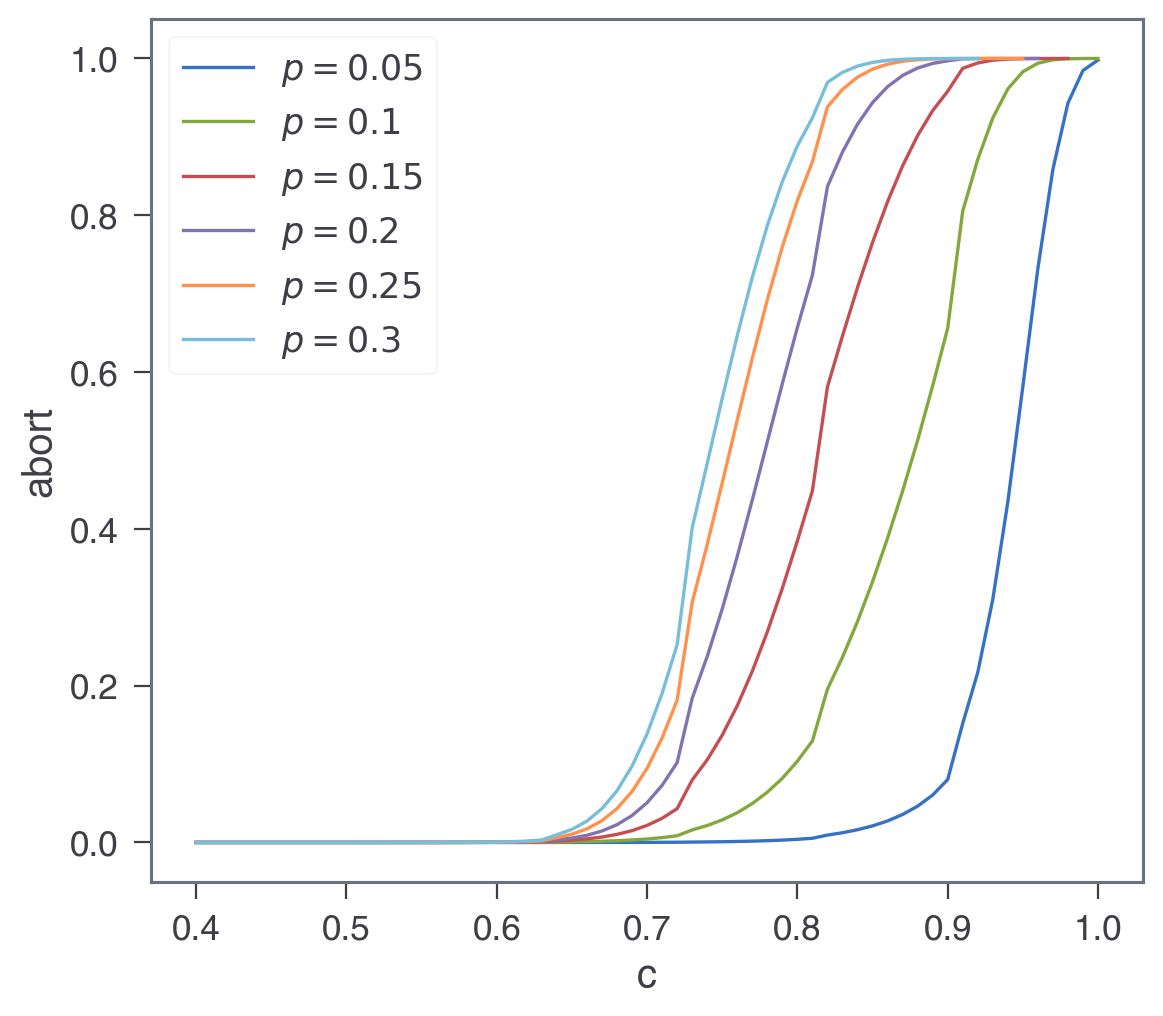

In [79]:
for p in np.arange(0.05, 0.301, 0.05).round(decimals=6):
#     color = cmap(i/len(plist)*0.8)
    df_p = df_PS.loc[idx[11, p, :], :].reset_index()
    sns.lineplot(df_p, x='c', y='fail', label=r'$p={}$'.format(p))
    plt.fill_between(df_p['c'], df_p['fail_low'], df_p['fail_upp'], alpha=.2)
plt.legend()

In [86]:
thrs_dict = {}
for c in clist:
    thrs = None
    for p in plist:
        if p < 0.08:
            continue
        try:
            fail_27 = df_PS.loc[(27, p, c), 'fail']
            fail_23 = df_PS.loc[(23, p, c), 'fail']
        except KeyError:
            continue
        if fail_27 >= fail_23:
            thrs = p
            break
    if thrs is not None:
        thrs_dict[c] = thrs

Text(0, 0.5, 'thrs')

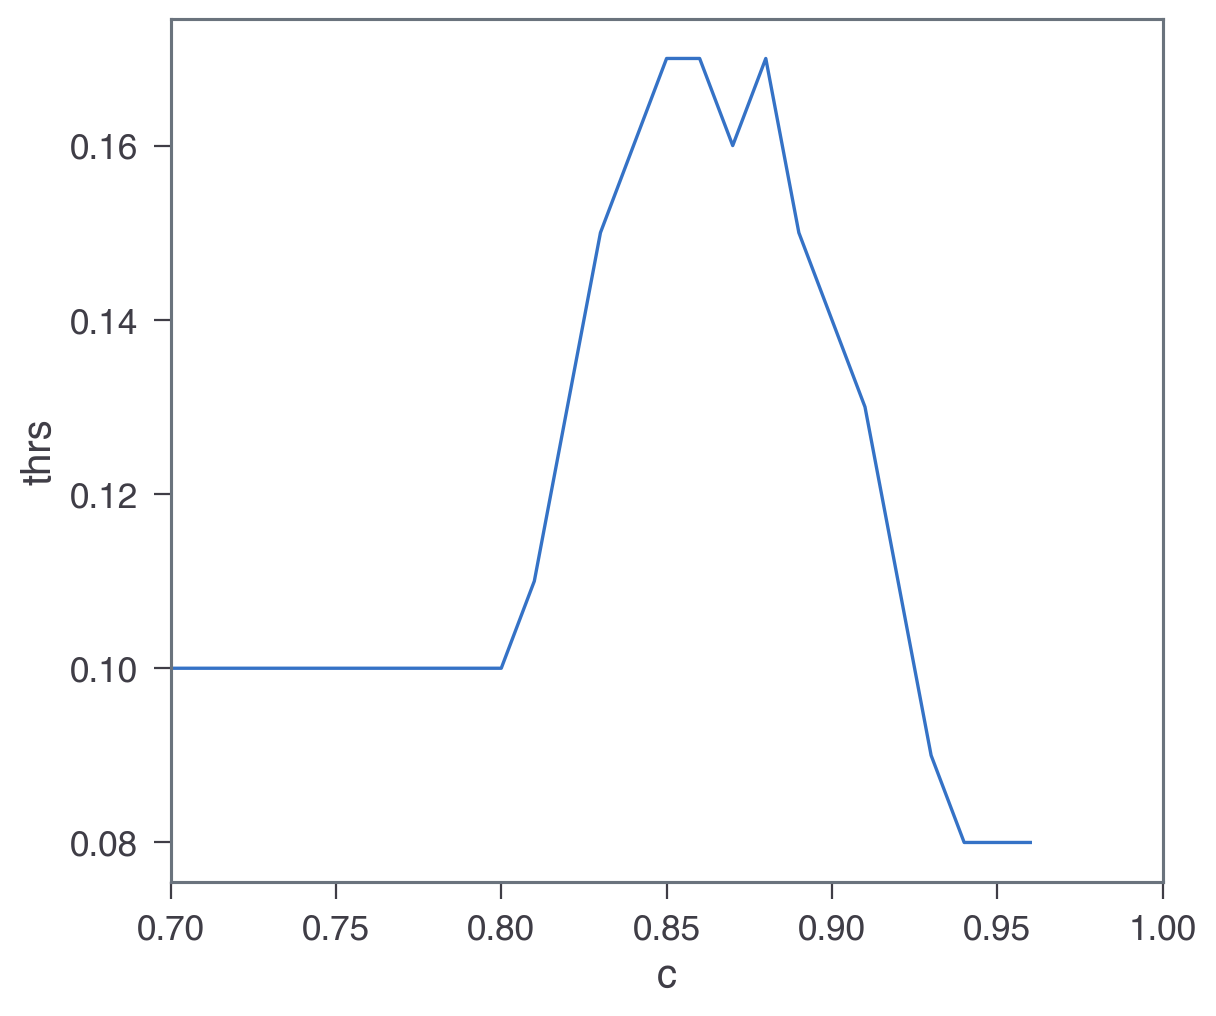

In [91]:
sns.lineplot(x=thrs_dict.keys(), y=thrs_dict.values())
plt.xlim(0.7, 1)
plt.xlabel('c')
plt.ylabel('thrs')

In [ ]:
# sample by sample comparison of logical gap, cluster frac, det density

In [76]:
from scipy.optimize import curve_fit

# Define a wrapper for curve_fit
def fitting_function(p_d, A, B, C, pth, nu0):
    p, d = p_d
    x = (p - pth) * d ** (1 / nu0)
    return A + B * x + C * x ** 2

# Prepare data for curve_fit
df = df_PS.loc[idx[:, 0.12:0.18, 0.8], :].reset_index()
p_values = df['p'].values
d_values = df['d'].values
fail_values = df['fail'].values
p_d_combined = np.array([p_values, d_values])

# Initial guesses for the parameters [A, B, C, pth, nu0]
initial_guess = [1, 1, 1, 0.1, 1]

# Perform curve fitting
popt, pcov = curve_fit(fitting_function, p_d_combined, fail_values, p0=initial_guess)

# Extract fitted parameters
A, B, C, pth, nu0 = popt

print("Fitted parameters:")
print(f"A = {A}, B = {B}, C = {C}, pth = {pth}, nu0 = {nu0}")

Fitted parameters:
A = 0.0980620425738666, B = 1.432762222354113, C = -1.2660188519535436, pth = 0.10298382073820825, nu0 = 1.9826306416373025


In [160]:
df_PS['accept_fail'] = (1 - df_PS['abort'])*df_PS['fail']
df_PS['accept_fail_low'] = (1 - df_PS['abort_upp'])*df_PS['fail_low']
df_PS['accept_fail_upp'] = (1 - df_PS['abort_low'])*df_PS['fail_upp']

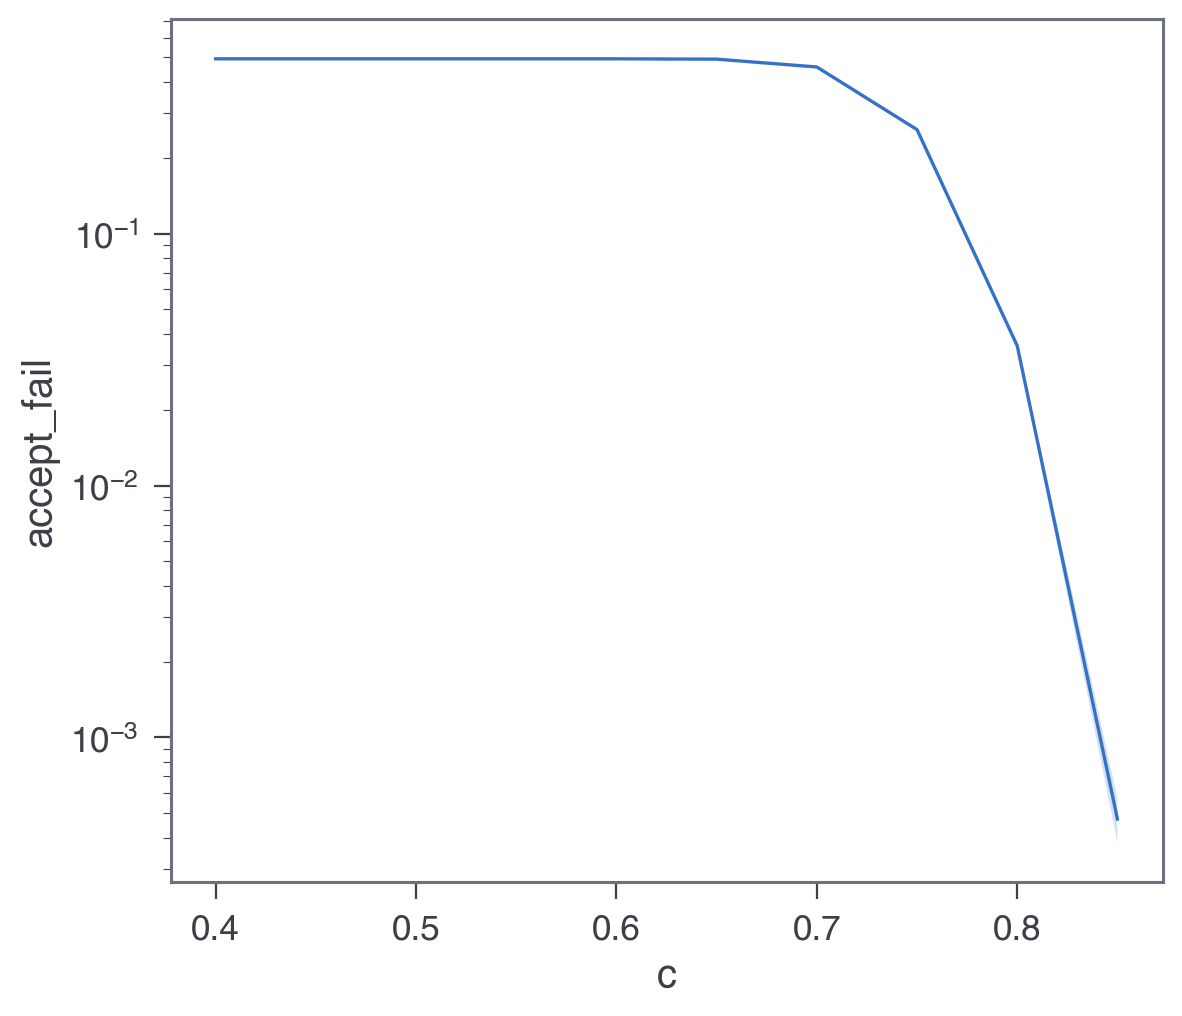

In [171]:
df = df_PS.loc[idx[19, 0.2, :], :].reset_index()
sns.lineplot(df, x='c', y='accept_fail')
plt.fill_between(df['c'], df['accept_fail_low'], df['accept_fail_upp'], alpha=.2)
plt.yscale('log')

# MCMC simulation

In [36]:
df_mc = pd.read_pickle('data/surface_code_bitflip_lsd0_ps').loc[idx[:, :, 'cluster_frac', :], :]
df_mc

fail    delta_fail         abort   delta_abort
d  p    strategy     c                                                       
11 0.01 cluster_frac 0.00  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
                     0.01  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
                     0.02  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
                     0.03  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
                     0.04  0.000001  9.960660e-07  3.898173e-07  3.898173e-07
...                             ...           ...           ...           ...
19 0.30 cluster_frac 0.82  0.495558  2.127454e-02  9.995718e-01  1.821488e-05
                     0.83  0.492458  4.022090e-02  9.998802e-01  9.599609e-06
                     0.84  0.389048  1.051113e-01  9.999824e-01  3.728761e-06
                     0.85  0.423205  2.270946e-01  9.999962e-01  1.729980e-06
                     0.86  0.475000  4.750000e-01  9.999994e-01  5.754197e-07

[14387 rows x 4 columns]

In [37]:
clist = [0.9, 0.95]
df_mc = df_mc.loc[idx[:, :, :, clist], :].reset_index().set_index(['c', 'd', 'p']).sort_index()
df_mc

strategy          fail    delta_fail     abort   delta_abort
c    d  p                                                                     
0.90 11 0.01  cluster_frac  1.390164e-06  9.960958e-07  0.000096  8.610353e-06
        0.02  cluster_frac  3.016253e-05  4.859448e-06  0.001455  3.345026e-05
        0.03  cluster_frac  2.543272e-04  1.407273e-05  0.008674  8.135009e-05
        0.04  cluster_frac  9.704130e-04  2.779622e-05  0.031132  1.522500e-04
        0.05  cluster_frac  2.498761e-03  4.565382e-05  0.080036  2.379000e-04
        0.06  cluster_frac  4.944554e-03  6.721464e-05  0.161639  3.227500e-04
        0.07  cluster_frac  8.459681e-03  9.429016e-05  0.273474  3.907500e-04
        0.08  cluster_frac  1.299256e-02  1.285138e-04  0.402787  4.299500e-04
        0.09  cluster_frac  1.871649e-02  1.745121e-04  0.535342  4.372000e-04
        0.10  cluster_frac  2.575949e-02  2.368466e-04  0.655801  4.165000e-04
        0.11  cluster_frac  3.433107e-02  3.243034e-04  0.757055  3.760000e-04
        0.12  cluster_frac  4.541566e-02  4.508489e-04  0.835647  3.248500e-04
        0.13  cluster_frac  5.847125e-02  6.284164e-04  0.892746  2.713424e-04
        0.14  cluster_frac  7.370044e-02  8.779344e-04  0.931885  2.209000e-04
        0.15  cluster_frac  9.464140e-02  1.252151e-03  0.957992  1.758500e-04
        0.16  cluster_frac  1.174803e-01  1.770228e-03  0.974445  1.383500e-04
        0.17  cluster_frac  1.441833e-01  2.508125e-03  0.984875  1.070501e-04
        0.18  cluster_frac  1.731202e-01  3.526935e-03  0.991111  8.231533e-05
        0.19  cluster_frac  2.002130e-01  4.887658e-03  0.994823  6.295013e-05
        0.20  cluster_frac  2.410886e-01  6.902957e-03  0.997030  4.775018e-05
        0.21  cluster_frac  2.738851e-01  9.385583e-03  0.998252  3.665024e-05
        0.22  cluster_frac  3.081034e-01  1.253882e-02  0.998951  2.839986e-05
        0.23  cluster_frac  3.388347e-01  1.639524e-02  0.999353  2.230552e-05
        0.24  cluster_frac  3.828720e-01  2.242858e-02  0.999638  1.672094e-05
        0.25  cluster_frac  3.976893e-01  2.888085e-02  0.999776  1.315072e-05
        0.26  cluster_frac  4.403481e-01  3.477025e-02  0.999843  1.099966e-05
        0.27  cluster_frac  4.937459e-01  4.481916e-02  0.999904  8.651184e-06
        0.28  cluster_frac  4.884271e-01  5.352013e-02  0.999930  7.351415e-06
        0.29  cluster_frac  4.544051e-01  6.111825e-02  0.999948  6.351649e-06
        0.30  cluster_frac  5.422303e-01  6.283354e-02  0.999951  6.244296e-06
     13 0.01  cluster_frac  3.898174e-07  3.898174e-07  0.000036  5.334630e-06
        0.02  cluster_frac  7.121267e-06  2.358185e-06  0.000853  2.559984e-05
        0.03  cluster_frac  8.938163e-05  8.396062e-06  0.006358  6.973827e-05
        0.04  cluster_frac  4.473030e-04  1.880994e-05  0.027122  1.424743e-04
        0.05  cluster_frac  1.275099e-03  3.265694e-05  0.079819  2.376000e-04
        0.06  cluster_frac  2.741542e-03  5.055775e-05  0.176186  3.339500e-04
        0.07  cluster_frac  4.944190e-03  7.417642e-05  0.312451  4.063500e-04
        0.08  cluster_frac  7.997766e-03  1.072845e-04  0.469580  4.375000e-04
        0.09  cluster_frac  1.199301e-02  1.552330e-04  0.621536  4.252000e-04
        0.10  cluster_frac  1.698642e-02  2.273720e-04  0.751288  3.789000e-04
        0.11  cluster_frac  2.346567e-02  3.401519e-04  0.847568  3.151000e-04
        0.12  cluster_frac  3.247541e-02  5.247574e-04  0.912137  2.482000e-04
        0.13  cluster_frac  4.313880e-02  8.154630e-04  0.952095  1.872673e-04
        0.14  cluster_frac  5.759134e-02  1.299303e-03  0.975217  1.363711e-04
        0.15  cluster_frac  7.466664e-02  2.069905e-03  0.987583  9.709994e-05
        0.16  cluster_frac  9.441347e-02  3.320264e-03  0.994006  6.773292e-05
        0.17  cluster_frac  1.189971e-01  5.384917e-03  0.997214  4.625018e-05
        0.18  cluster_frac  1.544245e-01  8.788027e-03  0.998691  3.175028e-05
        0.19  cluster_frac  1.825456e-01  1.389002e-02  0.999406  2.

In [7]:
from joblib import Parallel, delayed, parallel_backend

nonzero_prob_scale_e0_thrs = 1e-5
prms = []
for index in df_mc.index:
    c, d, p = index
    if p > 0.1:
        pfail, delta_pfail = df_mc.loc[index, ['fail', 'delta_fail']]
        if delta_pfail / pfail > 0.1:
            pabort = df_mc.loc[index, 'abort']
            if 1 - pabort > nonzero_prob_scale_e0_thrs:
                prob_scale_e0 = None
            else:
                paborts_lower_p = df_mc.loc[idx[c, d, :p], 'abort']
                paborts_lower_p = paborts_lower_p[1 - paborts_lower_p > nonzero_prob_scale_e0_thrs]
                selected_p = paborts_lower_p.index[-1][2]
                prob_scale_e0 = selected_p / p
            prms.append((c, d, p, prob_scale_e0))

In [24]:
num_chains = 1000

def task(c, d, p, prob_scale_e0):
    circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
    dem = circuit.detector_error_model()
    path = f'data/surface_code_bitflip_lsd0_mcmc_c{c}_d{d}_p{p}_Nc{num_chains}'
    with parallel_backend('loky', inner_max_num_threads=num_chains):
        data = metropolis_simulation(dem,
                                     c=c,
                                     init_shots=1000,
                                     R_tol=1.1,
                                     pfail_rel_diff_tol=0.1,
                                     num_chains=num_chains,
                                     prob_scale_e0=prob_scale_e0,
                                     pfail_ub=0.55,
                                     save_path=path,
                                     prev_data=path)
    return data['pfail']

with parallel_backend('loky', inner_max_num_threads=2):
    results = Parallel(n_jobs=2, verbose=3)(delayed(task)(*prm) for prm in prms)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 227.5min


KeyboardInterrupt: 

In [92]:
df_mc = pd.read_pickle('data/surface_code_bitflip_lsd0_ps')
df_mc = df_mc.loc[idx[:, 0.15:0.2, 'cluster_frac', 0.9], :]
df_mc

fail  delta_fail     abort   delta_abort
d  p    strategy     c                                                
11 0.15 cluster_frac 0.9  0.094641    0.001252  0.957992  1.758500e-04
   0.16 cluster_frac 0.9  0.117480    0.001770  0.974445  1.383500e-04
   0.17 cluster_frac 0.9  0.144183    0.002508  0.984875  1.070501e-04
   0.18 cluster_frac 0.9  0.173120    0.003527  0.991111  8.231533e-05
   0.19 cluster_frac 0.9  0.200213    0.004888  0.994823  6.295013e-05
   0.20 cluster_frac 0.9  0.241089    0.006903  0.997030  4.775018e-05
13 0.15 cluster_frac 0.9  0.074667    0.002070  0.987583  9.709994e-05
   0.16 cluster_frac 0.9  0.094413    0.003320  0.994006  6.773292e-05
   0.17 cluster_frac 0.9  0.118997    0.005385  0.997214  4.625018e-05
   0.18 cluster_frac 0.9  0.154424    0.008788  0.998691  3.175028e-05
   0.19 cluster_frac 0.9  0.182546    0.013890  0.999406  2.142861e-05
   0.20 cluster_frac 0.9  0.249363    0.023630  0.999741  1.413355e-05
15 0.15 cluster_frac 0.9  0.071178    0.003000  0.994305  6.603405e-05
   0.16 cluster_frac 0.9  0.098091    0.005414  0.997672  4.231894e-05
   0.17 cluster_frac 0.9  0.122837    0.009684  0.999097  2.644711e-05
   0.18 cluster_frac 0.9  0.156462    0.017171  0.999653  1.641738e-05
   0.19 cluster_frac 0.9  0.191471    0.031738  0.999881  9.642702e-06
   0.20 cluster_frac 0.9  0.232459    0.054757  0.999953  6.048405e-06
17 0.15 cluster_frac 0.9  0.065248    0.005409  0.998379  3.530692e-05
   0.16 cluster_frac 0.9  0.092747    0.011397  0.999491  1.984863e-05
   0.17 cluster_frac 0.9  0.114961    0.023172  0.999853  1.072194e-05
   0.18 cluster_frac 0.9  0.195824    0.054967  0.999959  5.731229e-06
   0.19 cluster_frac 0.9  0.087797    0.079060  0.999991  2.644215e-06
   0.20 cluster_frac 0.9  0.261285    0.204438  0.999997  1.618520e-06
19 0.15 cluster_frac 0.9  0.054379    0.009779  0.999585  1.794236e-05
   0.16 cluster_frac 0.9  0.073827    0.022471  0.999895  8.999616e-06
   0.17 cluster_frac 0.9  0.135163    0.066501  0.999978  4.120487e-06
   0.18 cluster_frac 0.9  0.286278    0.171368  0.999995  2.033192e-06
   0.19 cluster_frac 0.9  0.250000    0.250000  0.999999  9.960660e-07
   0.20 cluster_frac 0.9  0.525000    0.475000  0.999999  5.754197e-07

In [94]:
nonzero_prob_scale_e0_thrs = 1e-5
prms = []
for index in df_mc.index:
    d, p, _, c = index
    pfail, delta_pfail = df_mc.loc[index, ['fail', 'delta_fail']]
    if delta_pfail / pfail > 0.1:
        pabort = df_mc.loc[index, 'abort']
        if 1 - pabort > nonzero_prob_scale_e0_thrs:
            prob_scale_e0 = None
        else:
            paborts_lower_p = df_mc.loc[idx[d, :p, :, c], 'abort']
            paborts_lower_p = paborts_lower_p[1 - paborts_lower_p > nonzero_prob_scale_e0_thrs]
            selected_p = paborts_lower_p.index[-1][1]
            prob_scale_e0 = selected_p / p
        prms.append((c, d, p, prob_scale_e0))

In [95]:
prms

[(0.9, 15, 0.18, None),
 (0.9, 15, 0.19, None),
 (0.9, 15, 0.2, None),
 (0.9, 17, 0.16, None),
 (0.9, 17, 0.17, None),
 (0.9, 17, 0.18, None),
 (0.9, 17, 0.19, 0.9473684210526315),
 (0.9, 17, 0.2, 0.8999999999999999),
 (0.9, 19, 0.15, None),
 (0.9, 19, 0.16, None),
 (0.9, 19, 0.17, None),
 (0.9, 19, 0.18, 0.9444444444444445),
 (0.9, 19, 0.19, 0.8947368421052632),
 (0.9, 19, 0.2, 0.85)]

In [103]:
import os
import pickle

dirc = f'data/241128_surface_code_bitflip_lsd0_mcmc'
os.makedirs(dirc, exist_ok=True)
num_samples = 10_000_000
num_samples_each = 100_000

def task(c, d, p, prob_scale_e0, chain_id):
    circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
    dem = circuit.detector_error_model()
    path = os.path.join(dirc, f'c{c}_d{d}_p{p}_{chain_id}')
    try:
        with open(path, 'rb') as f:
            output = pickle.read(f)
        fails = output['fails']
        e0 = output['last_error']
        include_e0 = False
        num_batches = round((num_samples - len(fails)) / num_samples_each)
    except FileNotFoundError:
        fails = np.array([], dtype='bool')
        e0 = None
        include_e0 = True
        num_batches = round(num_samples / num_samples_each)
    for _ in range(num_batches):
        fails_sng, e0 = metropolis_sample(num_samples_each, 
                                          c=c, dem=dem, e0=e0, include_e0=include_e0,
                                          prob_scale_e0=prob_scale_e0)
        include_e0 = False
        fails = np.concatenate([fails, fails_sng])
        output = {
            'c': c,
            'd': d,
            'p': p,
            'prob_scale_e0': prob_scale_e0,
            'chain_id': chain_id,
            'fails': fails,
            'last_error': e0
        }
        with open(path, 'wb') as f:
            pickle.dump(output, f)
    return output

In [105]:
from joblib import Parallel, delayed

Nc = 4
output = Parallel(n_jobs=20, verbose=4)(
    delayed(task)(*prm, chain_id) for prm in prms for chain_id in range(Nc))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 out of  56 | elapsed: 358.2min remaining: 268.7min
[Parallel(n_jobs=20)]: Done  47 out of  56 | elapsed: 610.0min remaining: 116.8min
[Parallel(n_jobs=20)]: Done  56 out of  56 | elapsed: 716.1min finished


In [113]:
fails_dict = {}
for out in output:
    c, d, p, chain, fails = [out[key] for key in ['c', 'd', 'p', 'chain_id', 'fails']]
    try:
        fails_dict[(c, d, p)].append(fails)
    except KeyError:
        fails_dict[(c, d, p)] = [fails]

In [224]:
data = {}
for key, fails in fails_dict.items():
    fails = np.stack(fails, axis=0)
    shots = np.arange(1, fails.shape[1] + 1)
    pfails = fails.cumsum(axis=1) / shots
    variances = shots.reshape(1, -1) / (shots.reshape(1, -1) - 1) * pfails * (1 - pfails)
    B = shots * np.var(pfails, ddof=1, axis=0)
    W = np.mean(variances, axis=0)
    V = (shots - 1) / shots * W + (Nc + 1) / Nc / shots * B
    R = np.where(W > 0, np.sqrt(V / W), np.inf)
    data[key] = {
        'fails': fails,
        'pfails': pfails,
        'B': B,
        'W': W,
        'V': V,
        'R': R
    }

/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_1187/2908841568.py:6: RuntimeWarning: divide by zero encountered in divide
  variances = shots.reshape(1, -1) / (shots.reshape(1, -1) - 1) * pfails * (1 - pfails)
/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_1187/2908841568.py:6: RuntimeWarning: invalid value encountered in multiply
  variances = shots.reshape(1, -1) / (shots.reshape(1, -1) - 1) * pfails * (1 - pfails)
/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_1187/2908841568.py:10: RuntimeWarning: invalid value encountered in divide
  R = np.where(W > 0, np.sqrt(V / W), np.inf)
/var/folders/9m/ybt219fd4_d7npg9yjp5y8h40000gq/T/ipykernel_1187/2908841568.py:10: RuntimeWarning: divide by zero encountered in divide
  R = np.where(W > 0, np.sqrt(V / W), np.inf)


In [154]:
prms

[(0.9, 15, 0.18, None),
 (0.9, 15, 0.19, None),
 (0.9, 15, 0.2, None),
 (0.9, 17, 0.16, None),
 (0.9, 17, 0.17, None),
 (0.9, 17, 0.18, None),
 (0.9, 17, 0.19, 0.9473684210526315),
 (0.9, 17, 0.2, 0.8999999999999999),
 (0.9, 19, 0.15, None),
 (0.9, 19, 0.16, None),
 (0.9, 19, 0.17, None),
 (0.9, 19, 0.18, 0.9444444444444445),
 (0.9, 19, 0.19, 0.8947368421052632),
 (0.9, 19, 0.2, 0.85)]

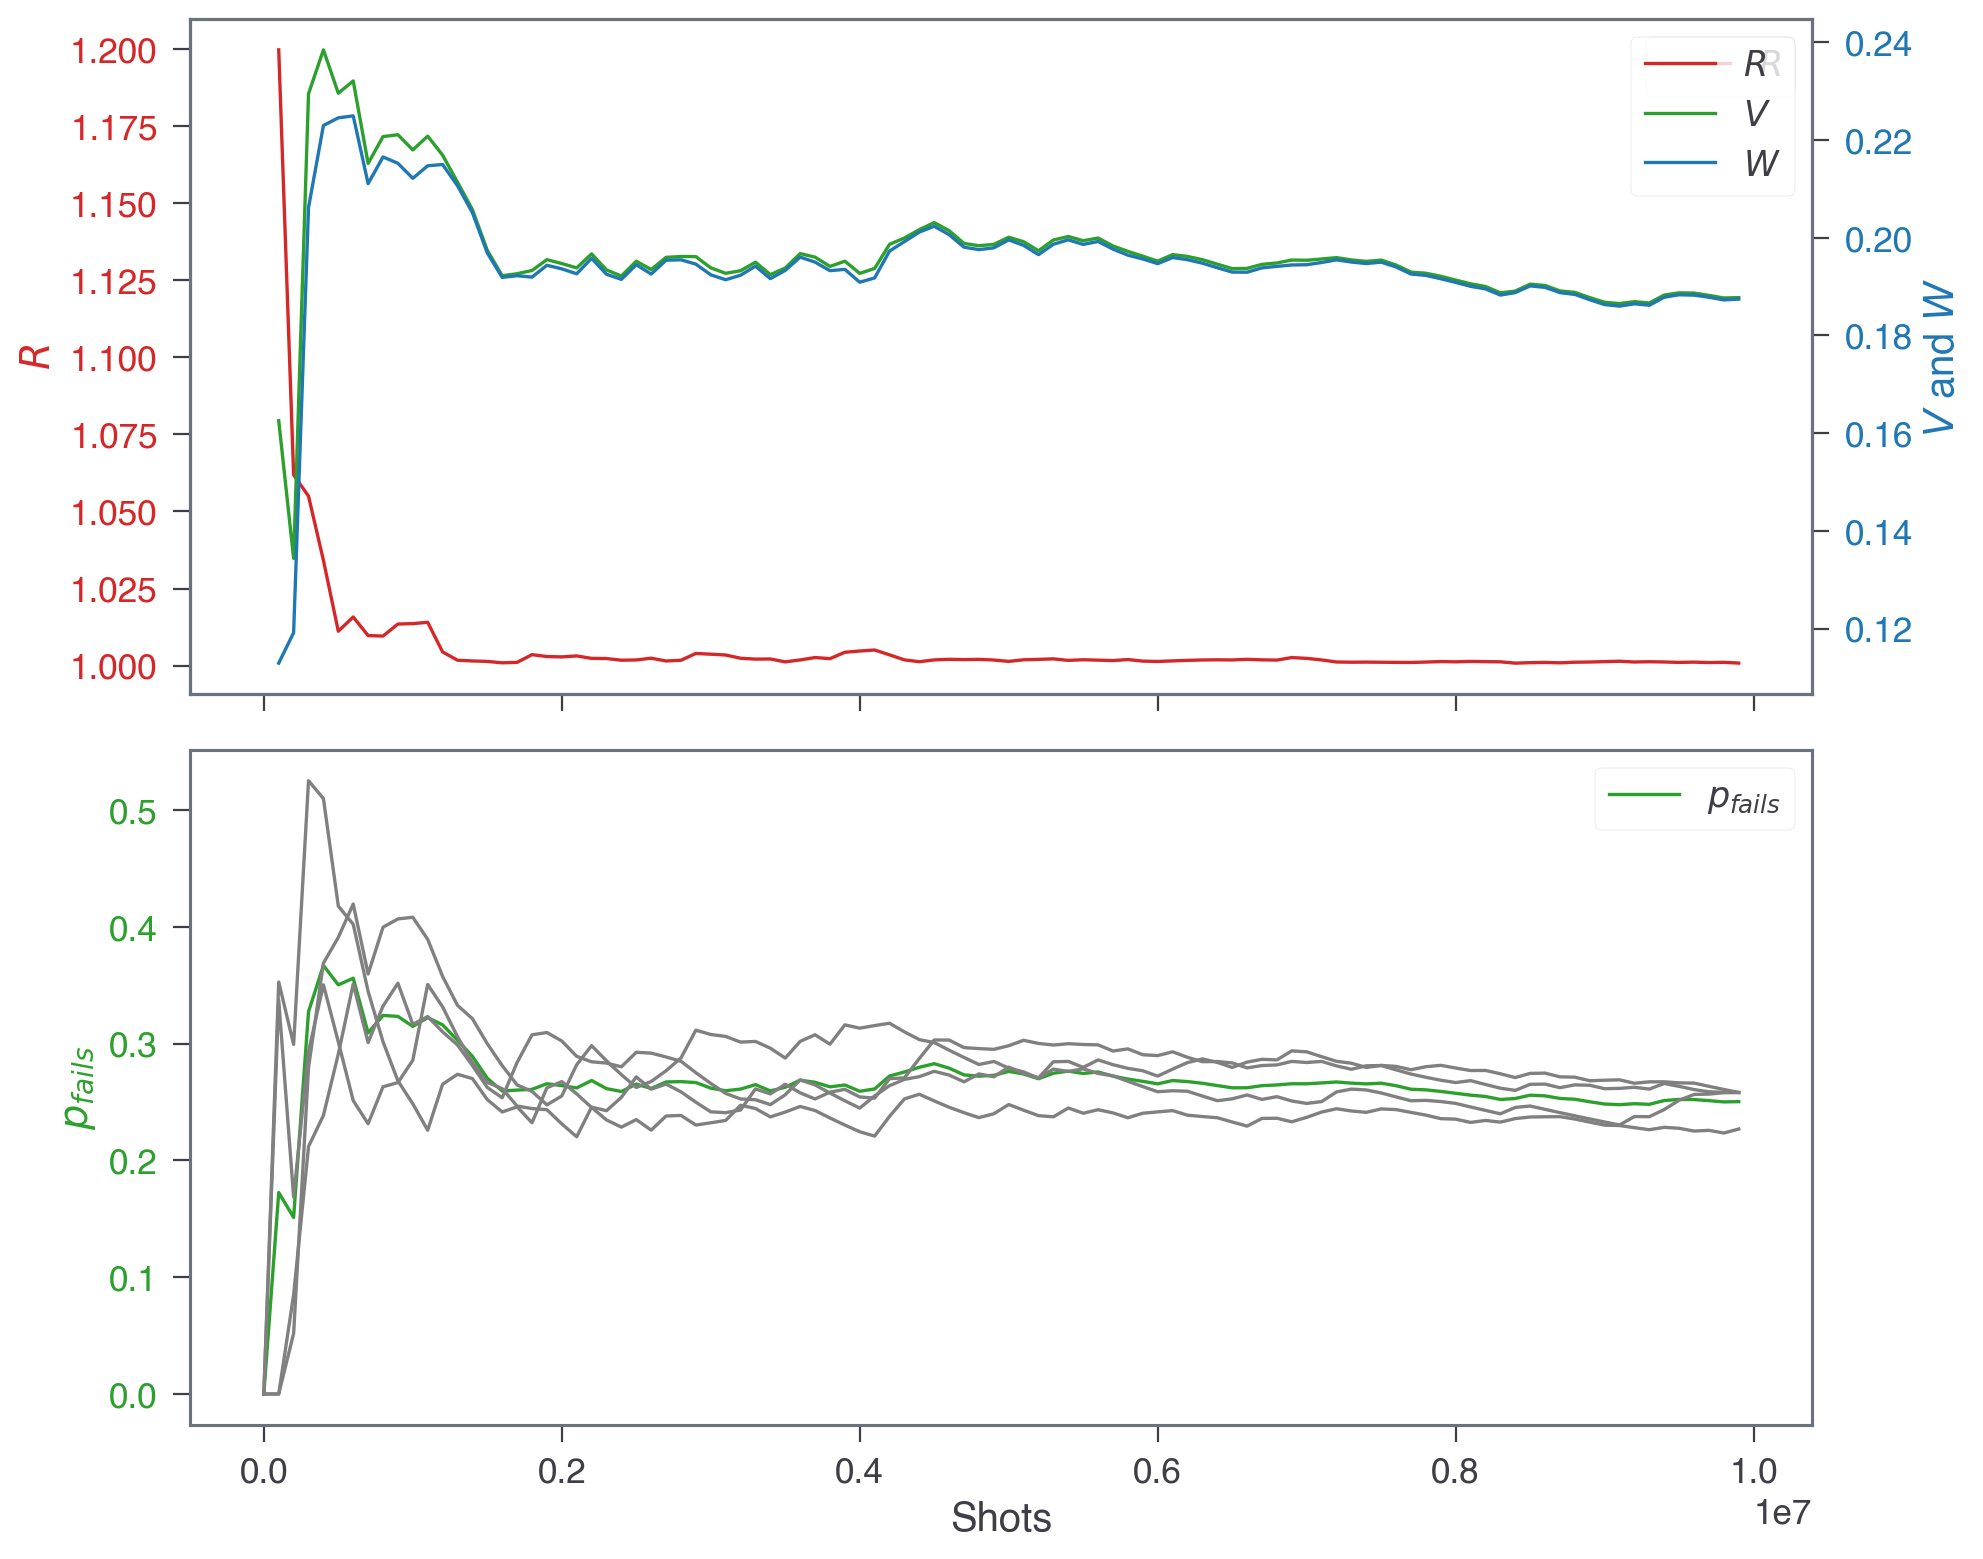

In [226]:
# Example data (replace this with your actual data extraction)
index = (0.9, 15, 0.2)
pfails_indv, V, W, R = [data[index][key] for key in ['pfails', 'V', 'W', 'R']]
pfails = np.mean(pfails_indv, axis=0)
shots = np.arange(1, V.shape[0] + 1)
# start = round(2e6)
start = 0
intv = round(1e5)
pfails_indv = pfails_indv[:, start::intv]
pfails = pfails[start::intv]
V = V[start::intv]
W = W[start::intv]
R = R[start::intv]
shots = shots[start::intv]

# Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot R on the primary y-axis of the first subplot
color_R = 'tab:red'
ax1.set_ylabel(r'$R$', color=color_R)
sns.lineplot(x=shots, y=R, label=r'$R$', ax=ax1, color=color_R)
ax1.tick_params(axis='y', labelcolor=color_R)

# Create a second y-axis for V and W in the first subplot
ax2 = ax1.twinx()
color_VW = 'tab:blue'
ax2.set_ylabel(r'$V$ and $W$', color=color_VW)
sns.lineplot(x=shots, y=V, label=r'$V$', ax=ax2, color='tab:green')
sns.lineplot(x=shots, y=W, label=r'$W$', ax=ax2, color='tab:blue')
ax2.tick_params(axis='y', labelcolor=color_VW)

# Add legends for the first subplot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Plot pfails in the second subplot
color_pfails = 'tab:green'
ax3.set_xlabel('Shots')
ax3.set_ylabel(r'$p_{fails}$', color=color_pfails)
sns.lineplot(x=shots, y=pfails, label=r'$p_{fails}$', ax=ax3, color=color_pfails)
for i, pfails_indv_chain in enumerate(pfails_indv):
    sns.lineplot(x=shots, y=pfails_indv_chain, ax=ax3, color='grey')
ax3.tick_params(axis='y', labelcolor=color_pfails)
ax3.legend(loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [238]:
lag = round(1e5)
np.corrcoef(fails[0, :-lag], fails[0, lag:])[0, 1]

0.022214230510936482

Text(0, 0.5, 'autocorrelation')

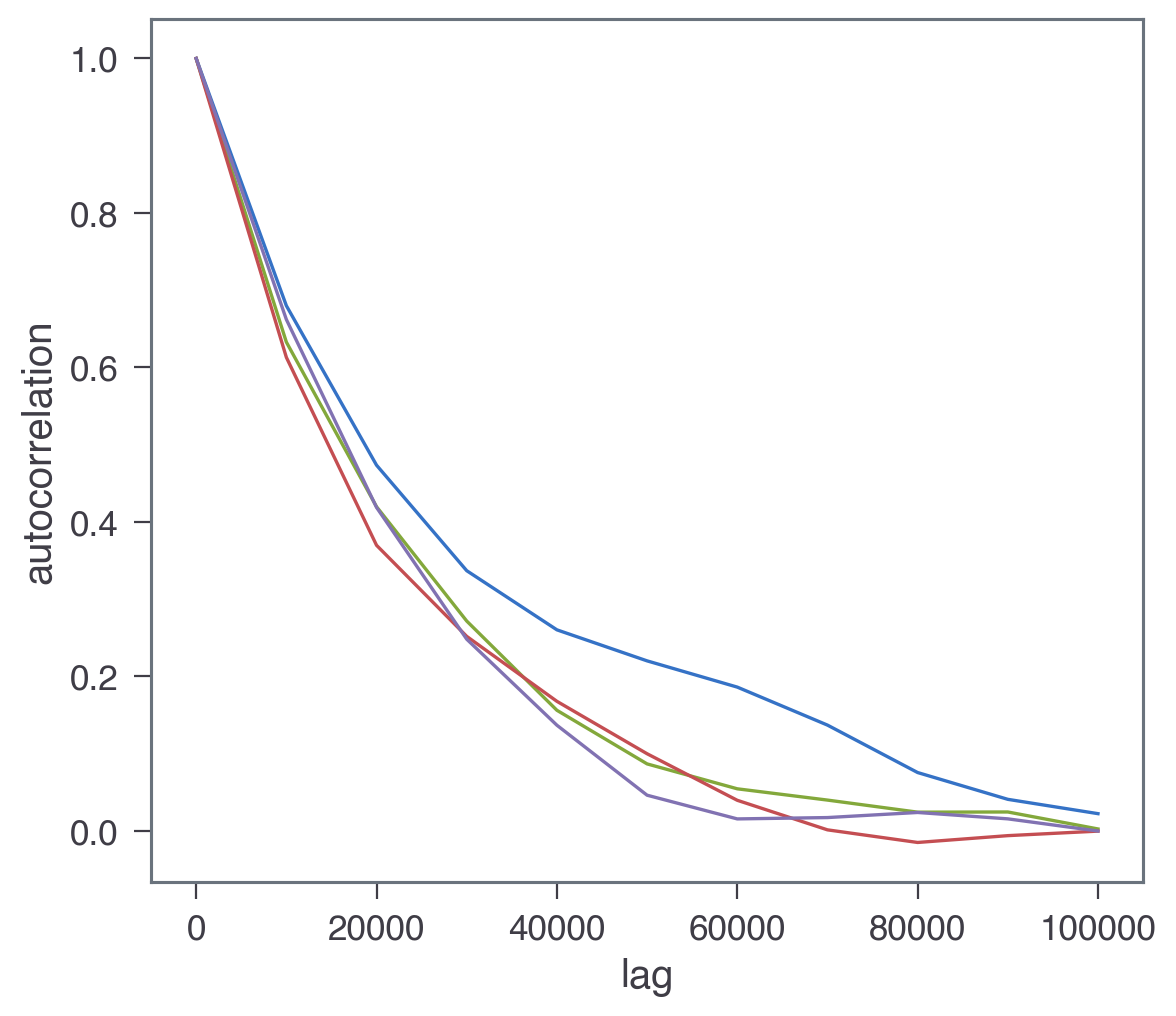

In [244]:
# Autocorrelation plot

fails = data[index]['fails']
acs = []
lags = range(1, 100_002, 10_000)
for chain in range(fails.shape[0]):
    acs_sng = []
    for lag in lags:
        ac = np.corrcoef(fails[chain, :-lag], fails[chain, lag:])[0, 1]
        if np.isnan(ac):
            break
        acs_sng.append(ac)
    acs.append(acs_sng)
for i in range(4):
    plt.plot(list(lags), acs[i])
plt.xlabel('lag')
plt.ylabel('autocorrelation')

In [156]:
pfails[-1]

0.2237991440606925

In [157]:
np.std(pfails[round(len(pfails) * 9/10):])

0.0014534393649240896

In [159]:
c, d, p = index
df_ps.loc[(d, p, 'cluster_frac', c)]

fail           5.250000e-01
delta_fail     4.750000e-01
abort          9.999994e-01
delta_abort    5.754197e-07
Name: (19, 0.2, cluster_frac, 0.9), dtype: float64

In [175]:
df_mc['mcmc'] = False
for (c, d, p), data_sng in data.items():
    pfails = np.mean(data_sng['pfails'], axis=0)
    delta_pfail = np.std(pfails[round(len(pfails) * 9/10):]) * 1.96
    df_mc.loc[(d, p, c), ['fail', 'delta_fail', 'mcmc']] = pfails[-1], delta_pfail, True

In [176]:
df_mc

fail  delta_fail     abort   delta_abort   mcmc  delta_pfail
d  p    c                                                                    
11 0.15 0.9  0.094641    0.001252  0.957992  1.758500e-04  False          NaN
   0.16 0.9  0.117480    0.001770  0.974445  1.383500e-04  False          NaN
   0.17 0.9  0.144183    0.002508  0.984875  1.070501e-04  False          NaN
   0.18 0.9  0.173120    0.003527  0.991111  8.231533e-05  False          NaN
   0.19 0.9  0.200213    0.004888  0.994823  6.295013e-05  False          NaN
   0.20 0.9  0.241089    0.006903  0.997030  4.775018e-05  False          NaN
13 0.15 0.9  0.074667    0.002070  0.987583  9.709994e-05  False          NaN
   0.16 0.9  0.094413    0.003320  0.994006  6.773292e-05  False          NaN
   0.17 0.9  0.118997    0.005385  0.997214  4.625018e-05  False          NaN
   0.18 0.9  0.154424    0.008788  0.998691  3.175028e-05  False          NaN
   0.19 0.9  0.182546    0.013890  0.999406  2.142861e-05  False          NaN
   0.20 0.9  0.249363    0.023630  0.999741  1.413355e-05  False          NaN
15 0.15 0.9  0.071178    0.003000  0.994305  6.603405e-05  False          NaN
   0.16 0.9  0.098091    0.005414  0.997672  4.231894e-05  False          NaN
   0.17 0.9  0.122837    0.009684  0.999097  2.644711e-05  False          NaN
   0.18 0.9  0.166191    0.001649  0.999653  1.641738e-05   True     0.001649
   0.19 0.9  0.205722    0.002074  0.999881  9.642702e-06   True     0.002074
   0.20 0.9  0.248258    0.002938  0.999953  6.048405e-06   True     0.002938
17 0.15 0.9  0.065248    0.005409  0.998379  3.530692e-05  False          NaN
   0.16 0.9  0.071530    0.001524  0.999491  1.984863e-05   True     0.001524
   0.17 0.9  0.102092    0.001532  0.999853  1.072194e-05   True     0.001532
   0.18 0.9  0.160196    0.002203  0.999959  5.731229e-06   True     0.002203
   0.19 0.9  0.195041    0.002644  0.999991  2.644215e-06   True     0.002644
   0.20 0.9  0.230215    0.003503  0.999997  1.618520e-06   True     0.003503
19 0.15 0.9  0.059719    0.000951  0.999585  1.794236e-05   True     0.000951
   0.16 0.9  0.060323    0.003296  0.999895  8.999616e-06   True     0.003296
   0.17 0.9  0.131903    0.002630  0.999978  4.120487e-06   True     0.002630
   0.18 0.9  0.099833    0.003817  0.999995  2.033192e-06   True     0.003817
   0.19 0.9  0.224961    0.011352  0.999999  9.960660e-07   True     0.011352
   0.20 0.9  0.221561    0.003335  0.999999  5.754197e-07   True     0.003335

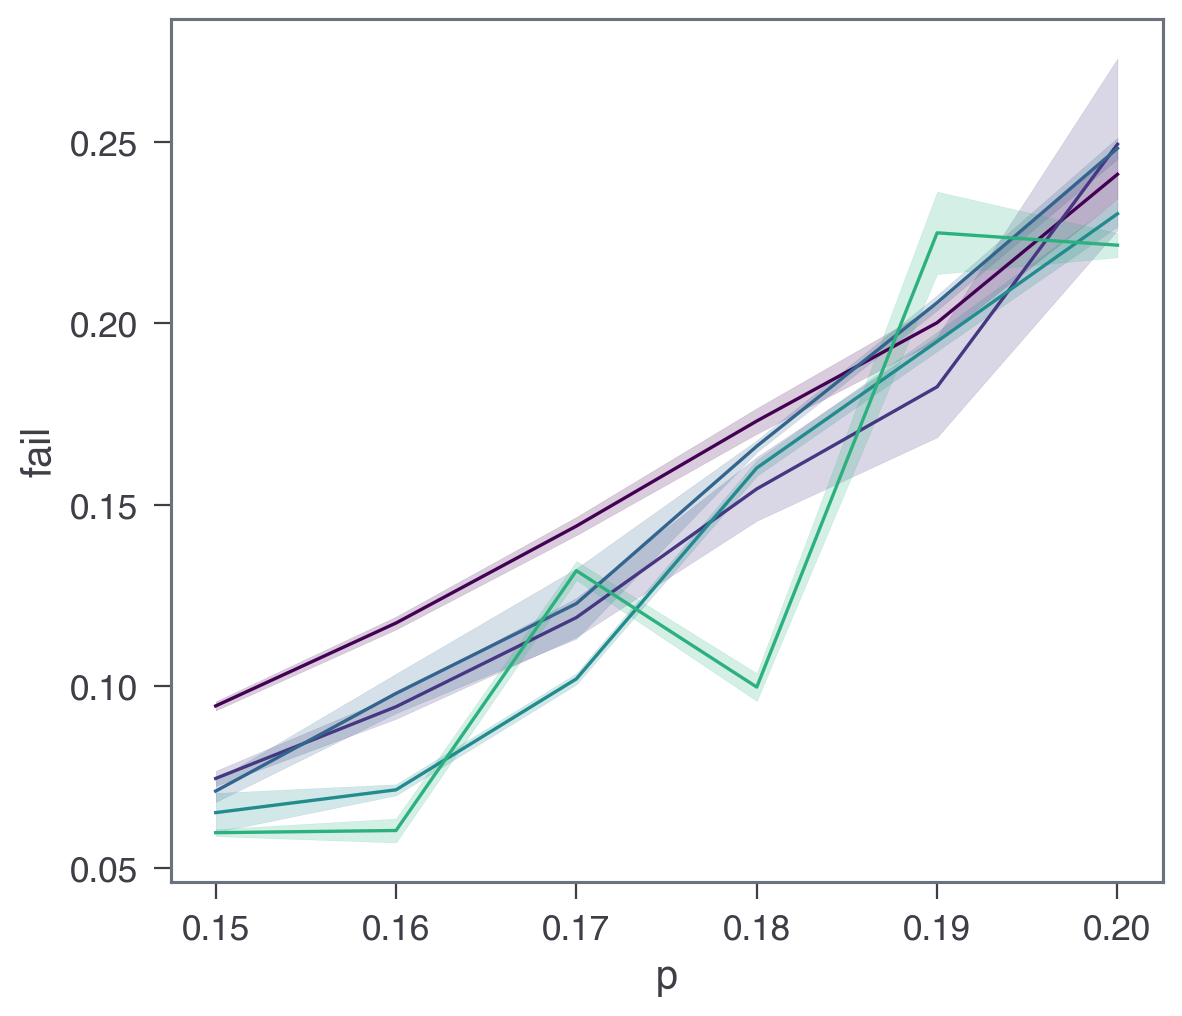

In [180]:
cmap = plt.cm.viridis
ds = df_mc.index.get_level_values('d').unique()
for i_d, d in enumerate(ds):
    color = cmap(i_d / len(ds) * 0.8)
    plot_error_band(df_mc.loc[idx[d, :, :], :].reset_index(), 
                    x='p', y='fail', delta_y='delta_fail', color=color)

# Failure rate estimation using KDE

347599
52401


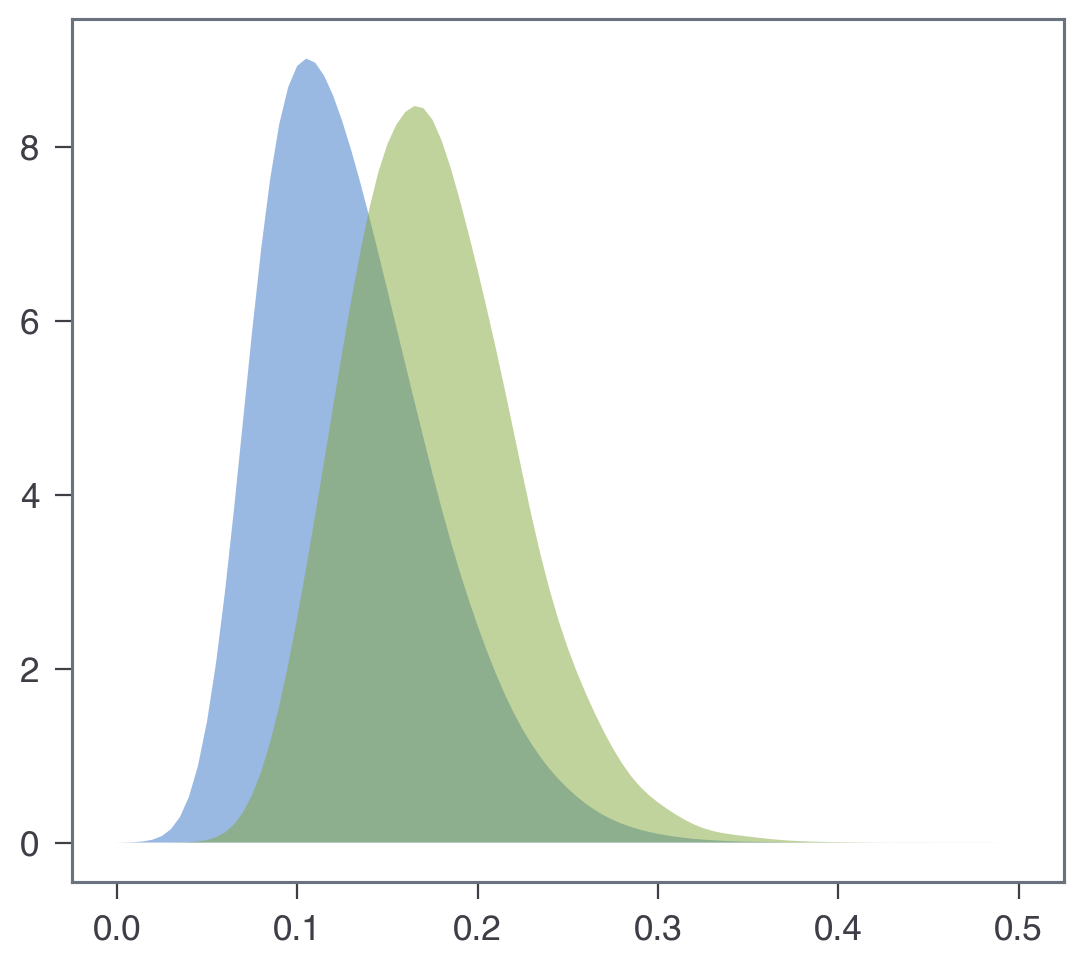

In [173]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

df = read_df(13)
df = df[df['p'] == 0.1]
cf_succ = np.array(df[df['fail']==0]['cluster_frac'])
cf_fail = np.array(df[df['fail']==1]['cluster_frac'])
print(len(cf_succ))
print(len(cf_fail))

cf_d = np.linspace(0, 0.5, 101)

kdes = []
for cf in [cf_succ, cf_fail]:
    kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
    kdes.append(kde)
    kde.fit(cf[:, None])
    pdf = np.exp(kde.score_samples(cf_d[:, None]))
    pdfs.append(pdf)
    plt.fill_between(cf_d, pdf, alpha=0.5)
plt.show()

Text(0, 0.5, 'autocorrelation')

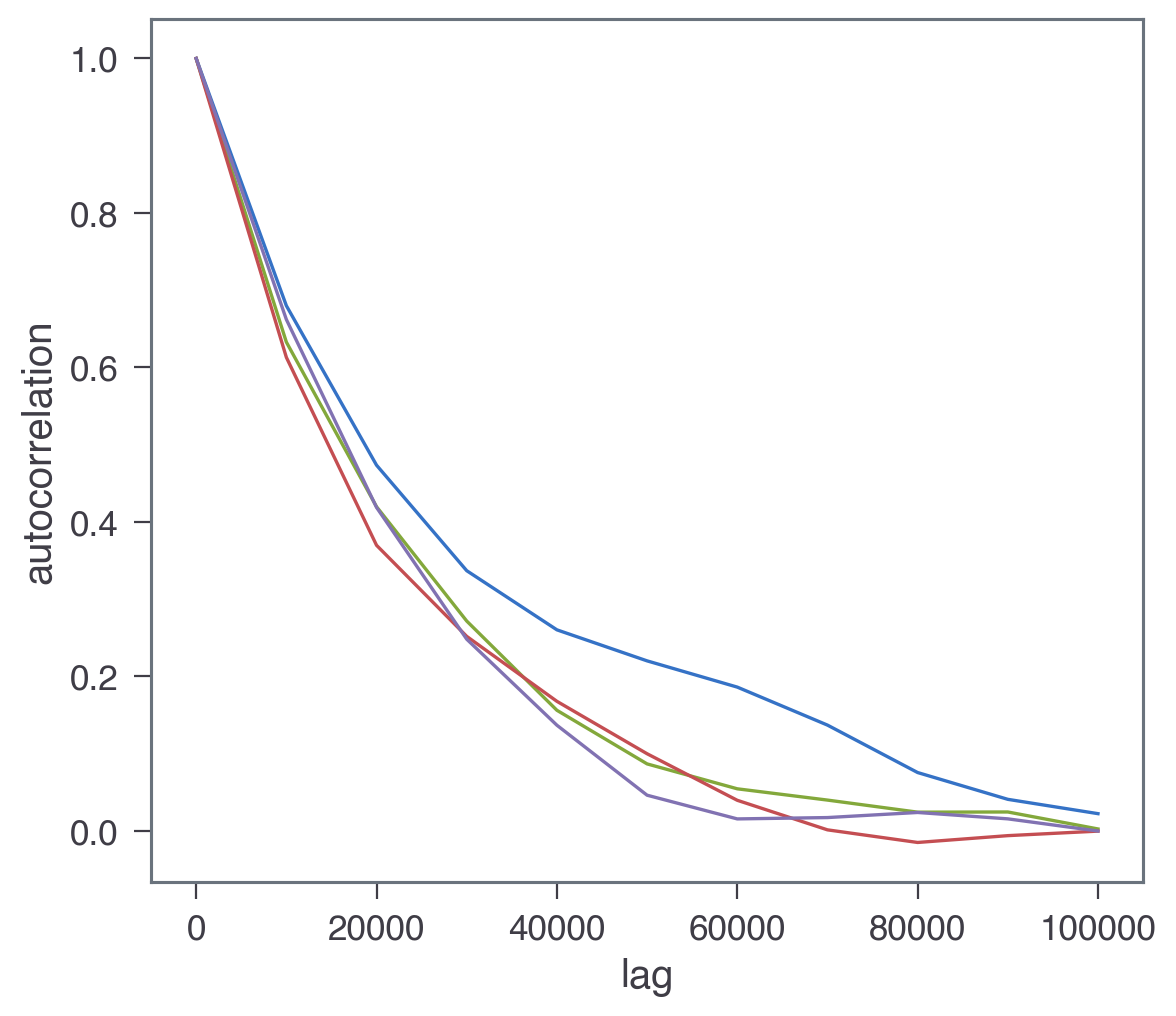

In [243]:
for i in range(4):
    plt.plot(list(lags), acs[i])
plt.xlabel('lag')
plt.ylabel('autocorrelation')

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

bandwidths = 10 ** np.linspace(-3, -2, 10)
grids = []
for cf in [cf_succ, cf_fail]:
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=5, verbose=3, n_jobs=1)
    grid.fit(cf[:, None])
    grids.append(grid)
    print(grid.best_params_)

In [99]:
from scipy.integrate import quad

def get_kdes(d, p, bandwidth, min_num_fail=None):
    df = read_df(d)
    df = df[df['p'] == p]
    cf_succ = df[df['fail']==0]['cluster_frac'].values
    cf_fail = df[df['fail']==1]['cluster_frac'].values
    
    if not len(df) or (min_num_fail is not None and len(cf_fail) < min_num_fail):
        raise ValueError
    
    kdes = []
    for cf in [cf_succ, cf_fail]:
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kdes.append(kde)
        kde.fit(cf[:, None])
    return kdes, len(cf_succ), len(cf_fail)

def estimate_probs(kde_succ, kde_fail, num_succ, num_fail, c):
    cdfs = []
    for kde in [kde_succ, kde_fail]:
        pdf = lambda cf: np.exp(kde.score_samples(np.array(cf).reshape(-1, 1)))[0]
        cdf, _ = quad(pdf, -np.inf, 1-c, complex_func=False)
        cdfs.append(cdf)
    num_samples = num_succ + num_fail
    cdfs[0] *= num_succ / num_samples
    cdfs[1] *= num_fail / num_samples
    
    p_fail = cdfs[1] / sum(cdfs)
    p_abort = 1 - sum(cdfs)
    return p_fail, p_abort

In [92]:
kdes, num_succ, num_fail = get_kdes(17, 0.2, 0.006)

In [96]:
estimate_probs(*kdes, num_succ, num_fail, 0.8)

(0.46851669907476823, 0.8785037266602138)

In [95]:
df_PS.loc[(17, 0.2, 0.8), :]

fail         0.467867
fail_low     0.463316
fail_upp     0.472417
abort        0.884209
abort_low    0.883217
abort_upp    0.885202
Name: (17.0, 0.2, 0.8), dtype: float64

In [105]:
df_PS_kde = pd.DataFrame(
    columns=['d', 'p', 'c', 'fail', 'abort'], 
    dtype='float64').set_index(['d', 'p', 'c'])

In [106]:
dlist = np.arange(11, 20, 2)
plist = np.arange(0.05, 0.31, 0.05).round(decimals=6)
clist = np.arange(0.4, 1.0001, 0.05).round(decimals=6)
for d in dlist:
    for p in plist:
        print(d, p)
        try:
            kdes, num_succ, num_fail = get_kdes(d, p, 0.006, min_num_fail=1000)
        except ValueError:
            continue
        for c in clist:
            fail, abort = estimate_probs(*kdes, num_succ, num_fail, c)
            df_PS_kde.loc[(d, p, c), :] = [fail, abort]

11 0.05
11 0.1
11 0.15
11 0.2
11 0.25
11 0.3
13 0.05
13 0.1
13 0.15
13 0.2
13 0.25
13 0.3
15 0.05
15 0.1
15 0.15
15 0.2
15 0.25
15 0.3
17 0.05
17 0.1
17 0.15
17 0.2
17 0.25
17 0.3
19 0.05
19 0.1
19 0.15
19 0.2
19 0.25
19 0.3


In [114]:
df_PS_kde.loc[idx[13, :, 0.9], 'fail']

d     p     c  
13.0  0.05  0.9    0.001337
      0.10  0.9    0.018749
      0.15  0.9    0.085064
      0.20  0.9    0.250513
      0.25  0.9    0.161089
      0.30  0.9    0.083684
Name: fail, dtype: float64

In [145]:
df_PS.loc[(13, 0.25, 0.9), ('abort', 'abort_low', 'abort_upp')]

abort        0.999985
abort_low    0.999974
abort_upp    0.999997
Name: (13.0, 0.25, 0.9), dtype: float64

In [159]:
kdes, num_succ, num_fail = get_kdes(13, 0.25, 0.019)
print(estimate_probs(*kdes, num_succ, num_fail, 0.9))

(0.47025565375711703, 0.9998435816541327)


In [126]:
np.exp(kdes[0].score_samples(np.array([0.1]).reshape(-1, 1)))

array([0.00287767])

In [127]:
np.exp(kdes[1].score_samples(np.array([0.1]).reshape(-1, 1)))

array([0.0005965])

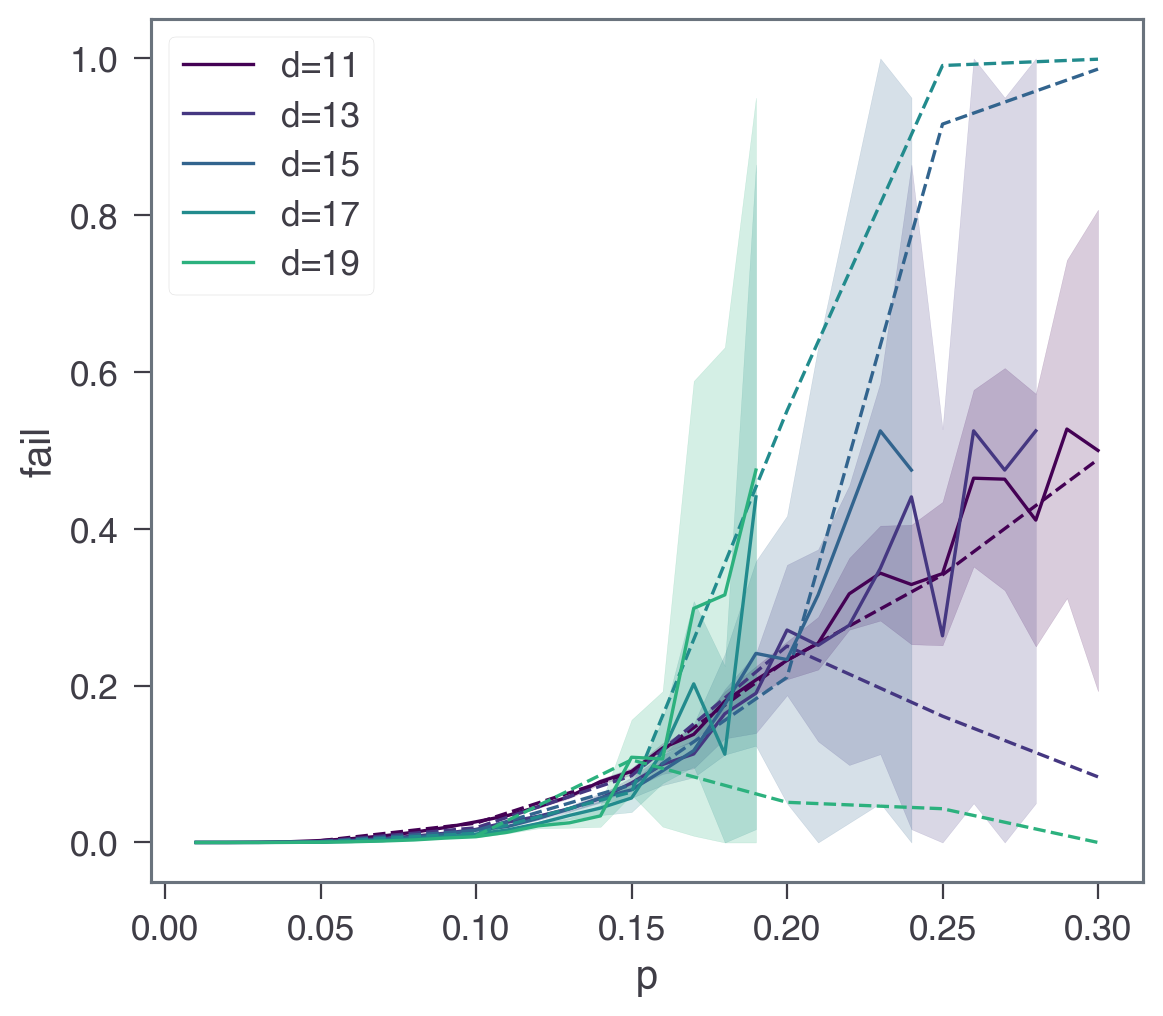

In [113]:
cmap = plt.cm.viridis
clist_plot = [0.9]
# clist_plot = np.round(clist_plot, decimals=6)
for i_d, d in enumerate(dlist):
    color = cmap(i_d/len(dlist)*0.8)
    for c in clist_plot:
        df_partial = df_PS.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_partial, x='p', y='fail', color=color, label=r'd={}'.format(d))
        plt.fill_between(x=df_partial['p'], 
                         y1=df_partial['fail_low'],
                         y2=df_partial['fail_upp'],
                         color=color,
                         alpha=.2)
        df_kde_partial = df_PS_kde.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_kde_partial, x='p', y='fail', color=color, linestyle='--')
        
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

# Failure rate estimation using skew normal dist

215483
184517


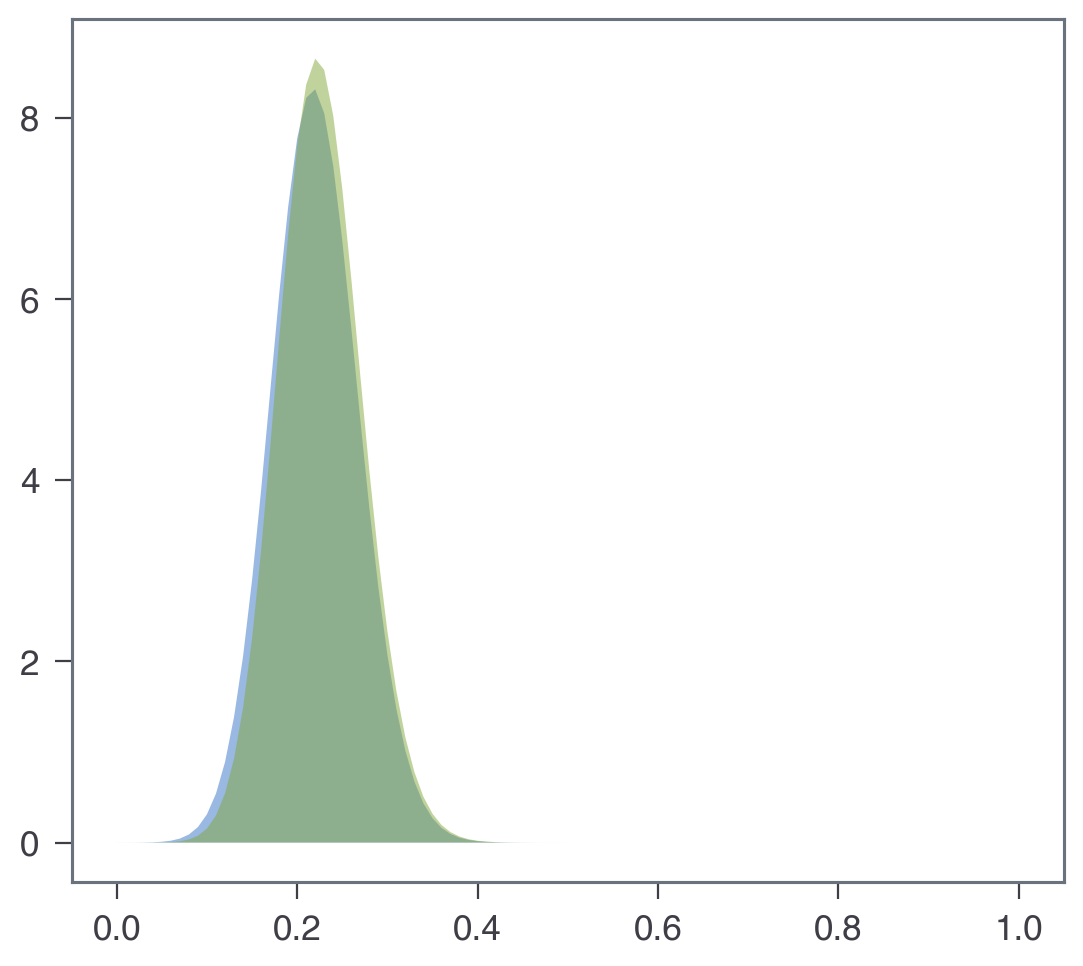

In [231]:
from scipy.stats import skewnorm

df = read_df(11)
df = df[df['p'] == 0.2]
cf_succ = df[df['fail']==0]['cluster_frac'].values
cf_fail = df[df['fail']==1]['cluster_frac'].values
print(len(cf_succ))
print(len(cf_fail))

cf_d = np.linspace(0, 1, 101)

for cf in [cf_succ, cf_fail]:
    params = skewnorm.fit(cf)  # Fit data to a Gaussian
    pdf = skewnorm.pdf(cf_d, *params)
    plt.fill_between(cf_d, pdf, alpha=0.5)
plt.show()

In [222]:
def fit_data(d, p, exponent=1, min_num_fail=None):
    df = read_df(d)
    df = df[df['p'] == p]
    cf_succ = df[df['fail']==0]['cluster_frac'].values**exponent
    cf_fail = df[df['fail']==1]['cluster_frac'].values**exponent
    
    if not len(df) or (min_num_fail is not None and len(cf_fail) < min_num_fail):
        raise ValueError
    
    prms = []
    for cf in [cf_succ, cf_fail]:
        prms_sng = skewnorm.fit(cf)
        prms_sng = list(prms_sng)
        prms_sng.append(exponent)
        prms.append(prms_sng)
    return prms, len(cf_succ), len(cf_fail)

def estimate_probs(prms_succ, prms_fail, num_succ, num_fail, c):
    cdfs = []
    for prms in [prms_succ, prms_fail]:
        cdf = skewnorm.cdf((1 - c)**prms[-1], *prms[:-1])
        cdfs.append(cdf)
    num_samples = num_succ + num_fail
    cdfs[0] *= num_succ / num_samples
    cdfs[1] *= num_fail / num_samples
    cdf_tot = cdfs[0] + cdfs[1]
    p_fail = cdfs[1] / cdf_tot
    p_abort = 1 - cdf_tot
    return p_fail, p_abort

In [223]:
from itertools import product

prms_dict = {}
df_PS_est = pd.DataFrame(
    columns=['d', 'p', 'c', 'fail', 'abort'], 
    dtype='float64')

# dlist = np.arange(11, 20, 2)
dlist = [11]
plist = np.arange(0.05, 0.301, 0.01).round(decimals=6)
clist = np.arange(0.4, 1.0001, 0.05).round(decimals=6)
dplist = list(product(dlist, plist))
for d, p in tqdm(dplist):
    try:
        params, num_succ, num_fail = fit_data(d, p, min_num_fail=1000, exponent=0.5)
    except ValueError:
        continue
    prms_dict[(d, p)] = params
    fail, abort = estimate_probs(*params, num_succ, num_fail, clist)
    df_partial = pd.DataFrame({'c': clist, 'fail': fail, 'abort': abort})
    df_partial['d'] = d
    df_partial['p'] = p
    df_PS_est = pd.concat([df_PS_est, df_partial], axis=0)

100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


In [224]:
df_PS_est = df_PS_est.set_index(['d', 'p', 'c']).sort_index()

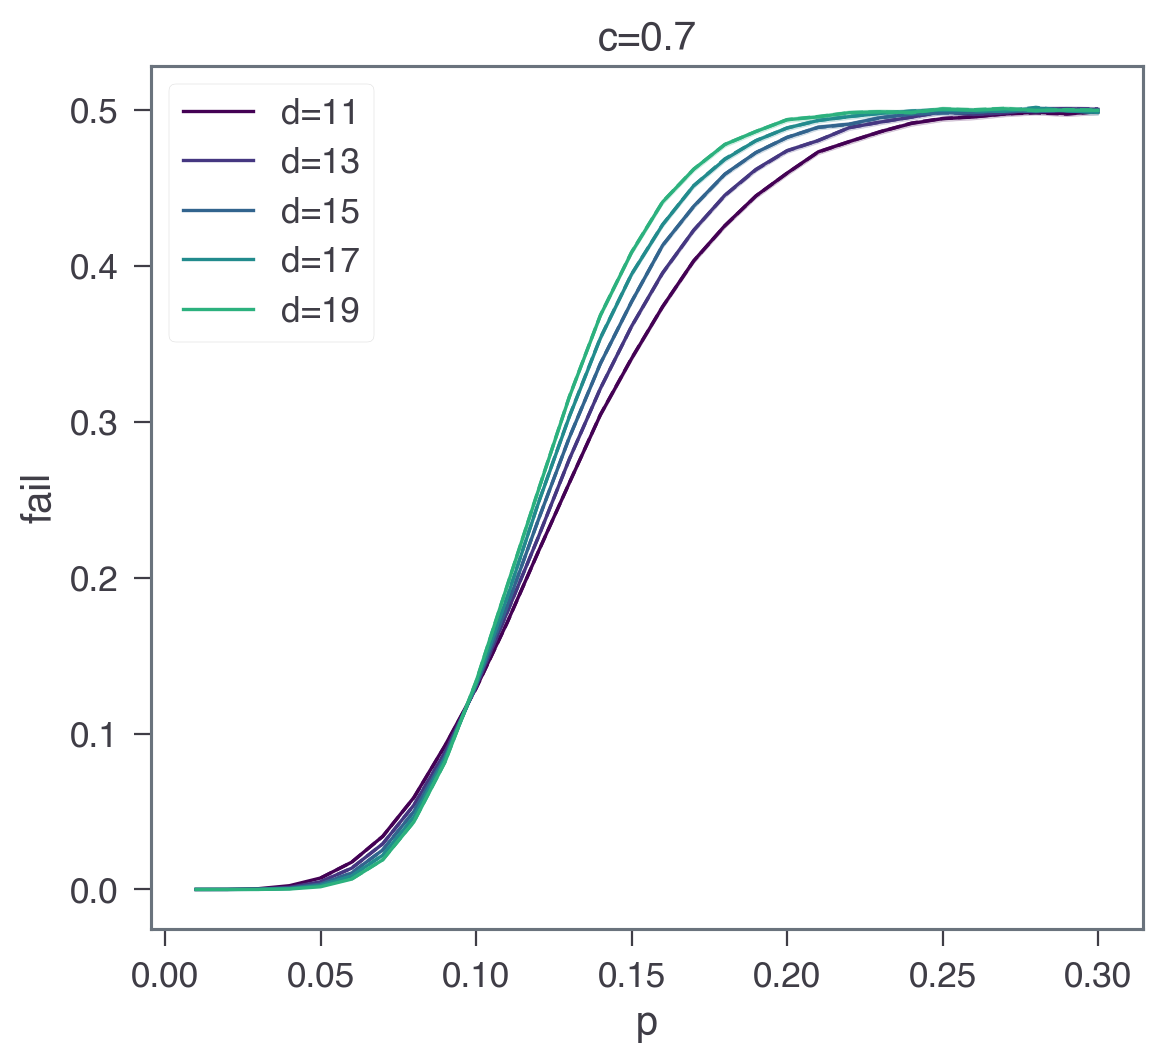

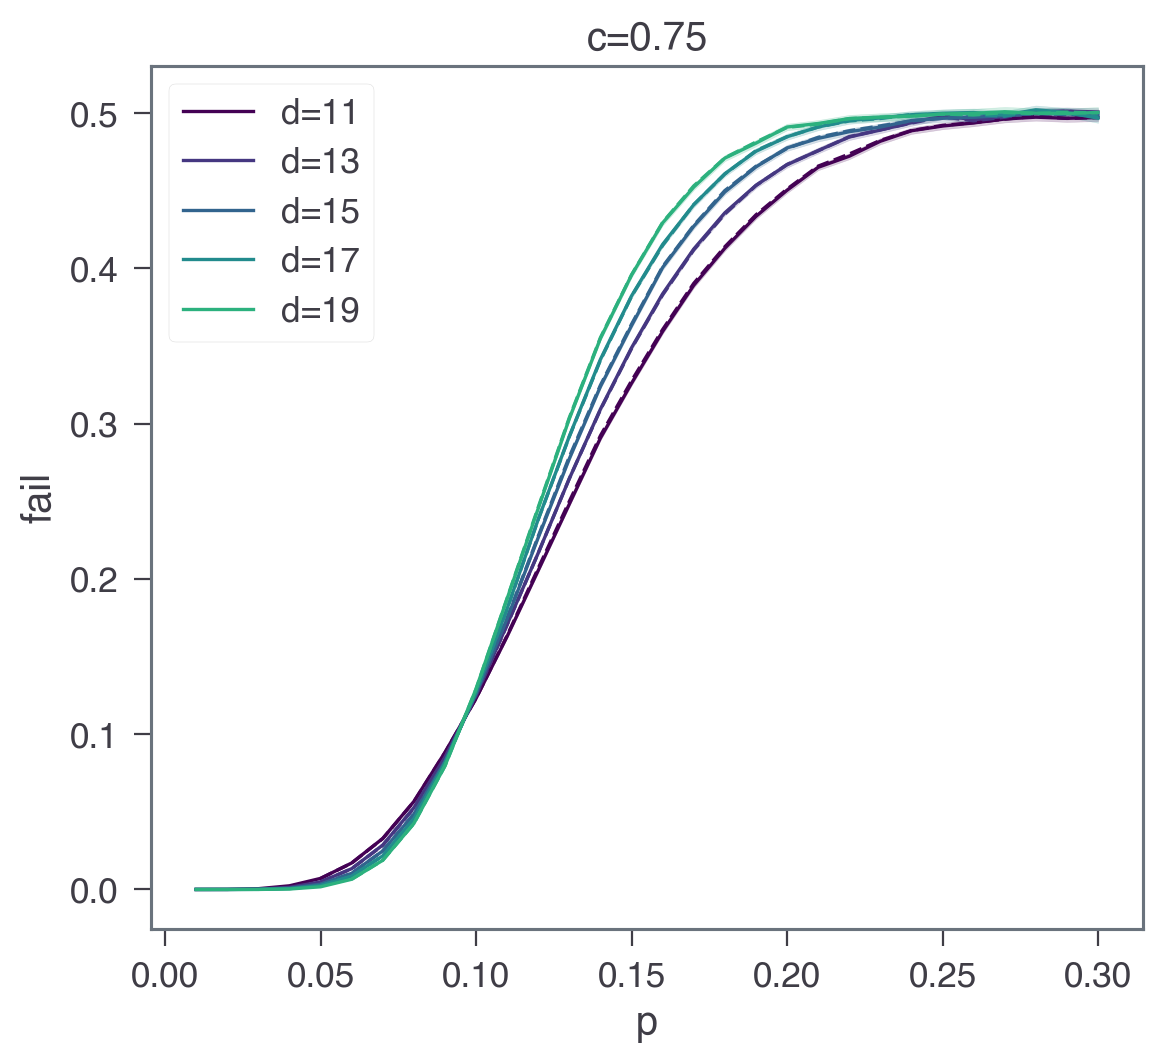

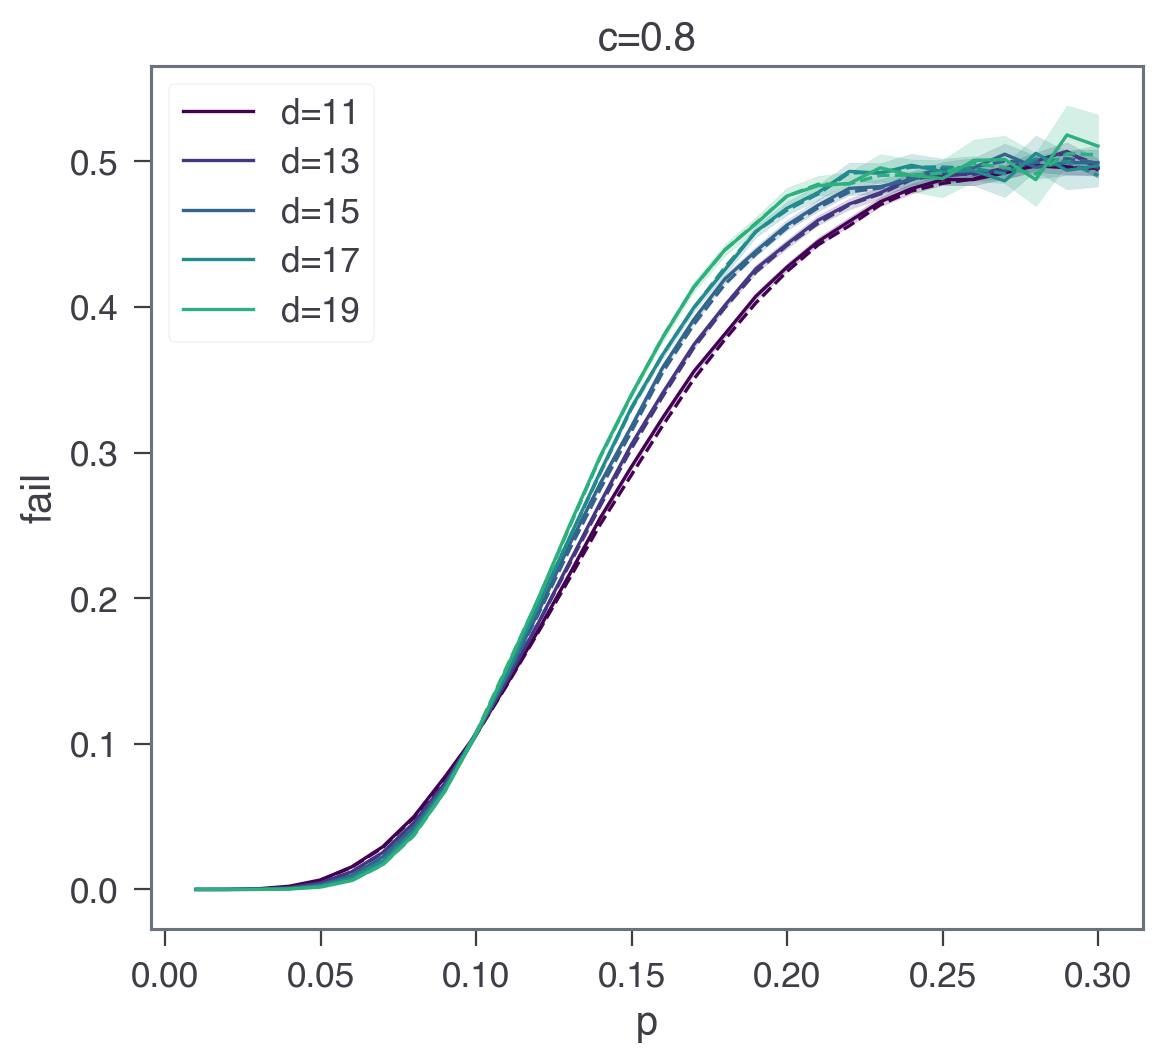

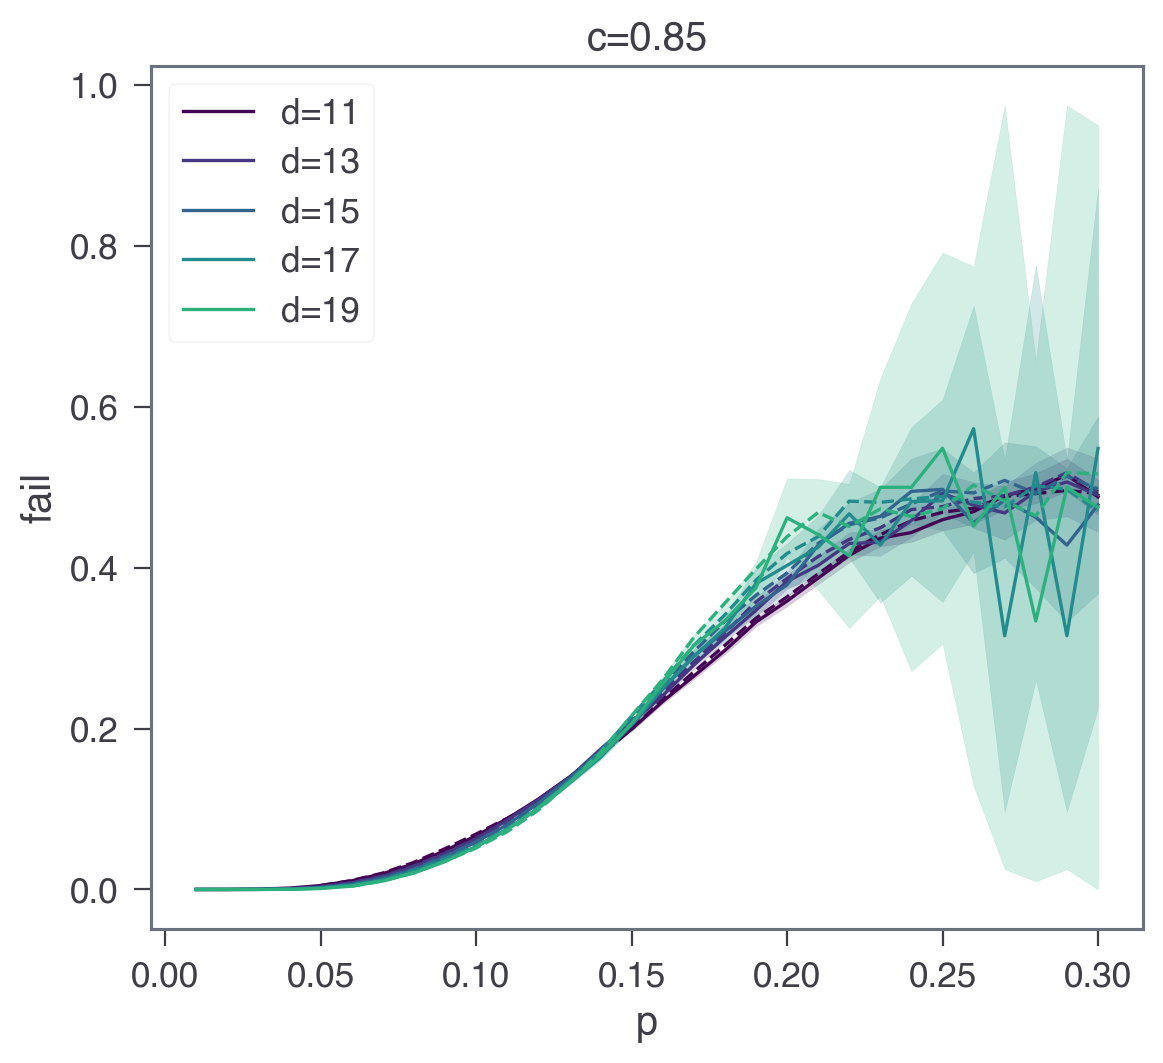

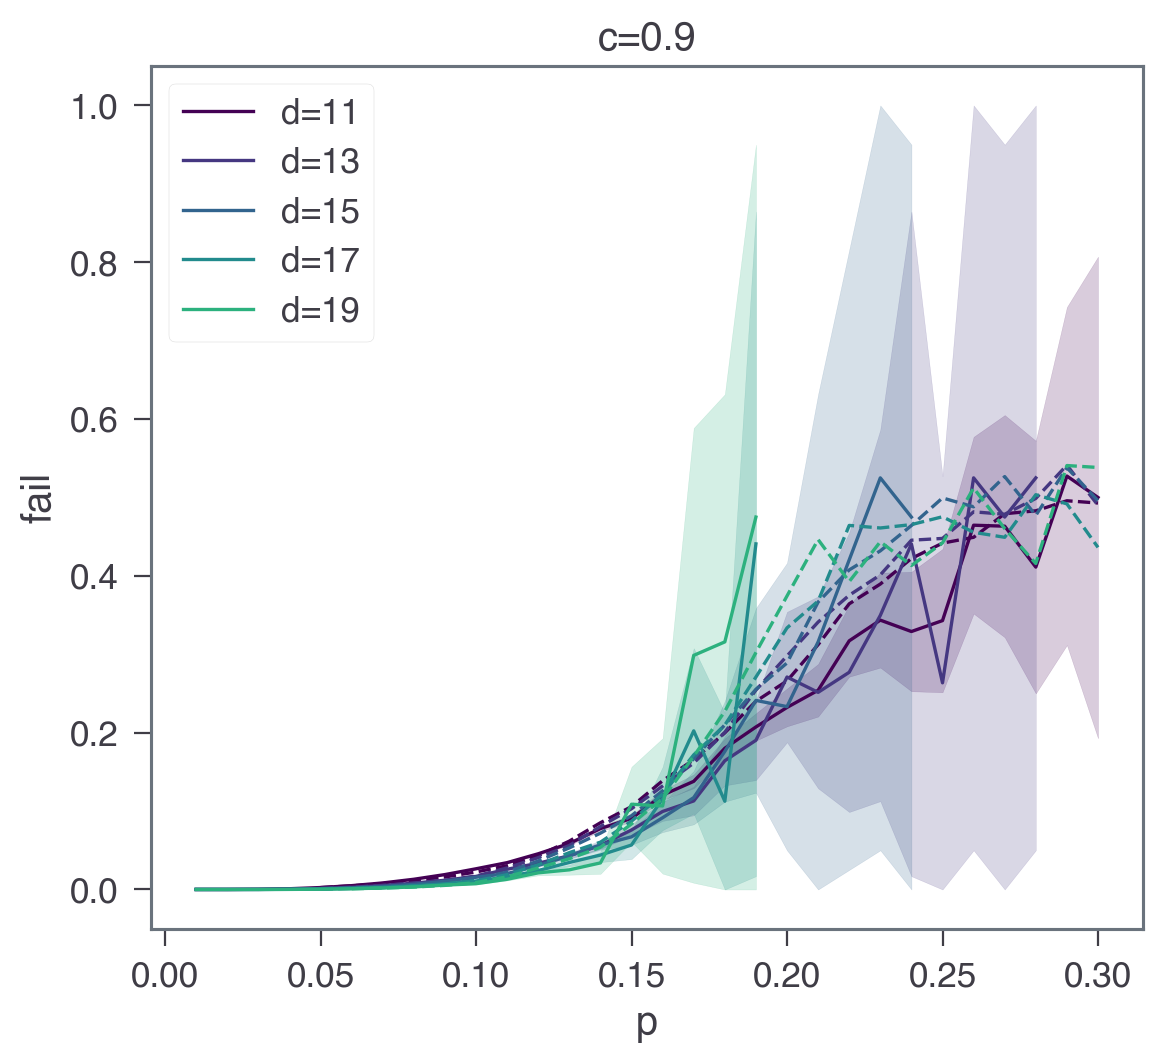

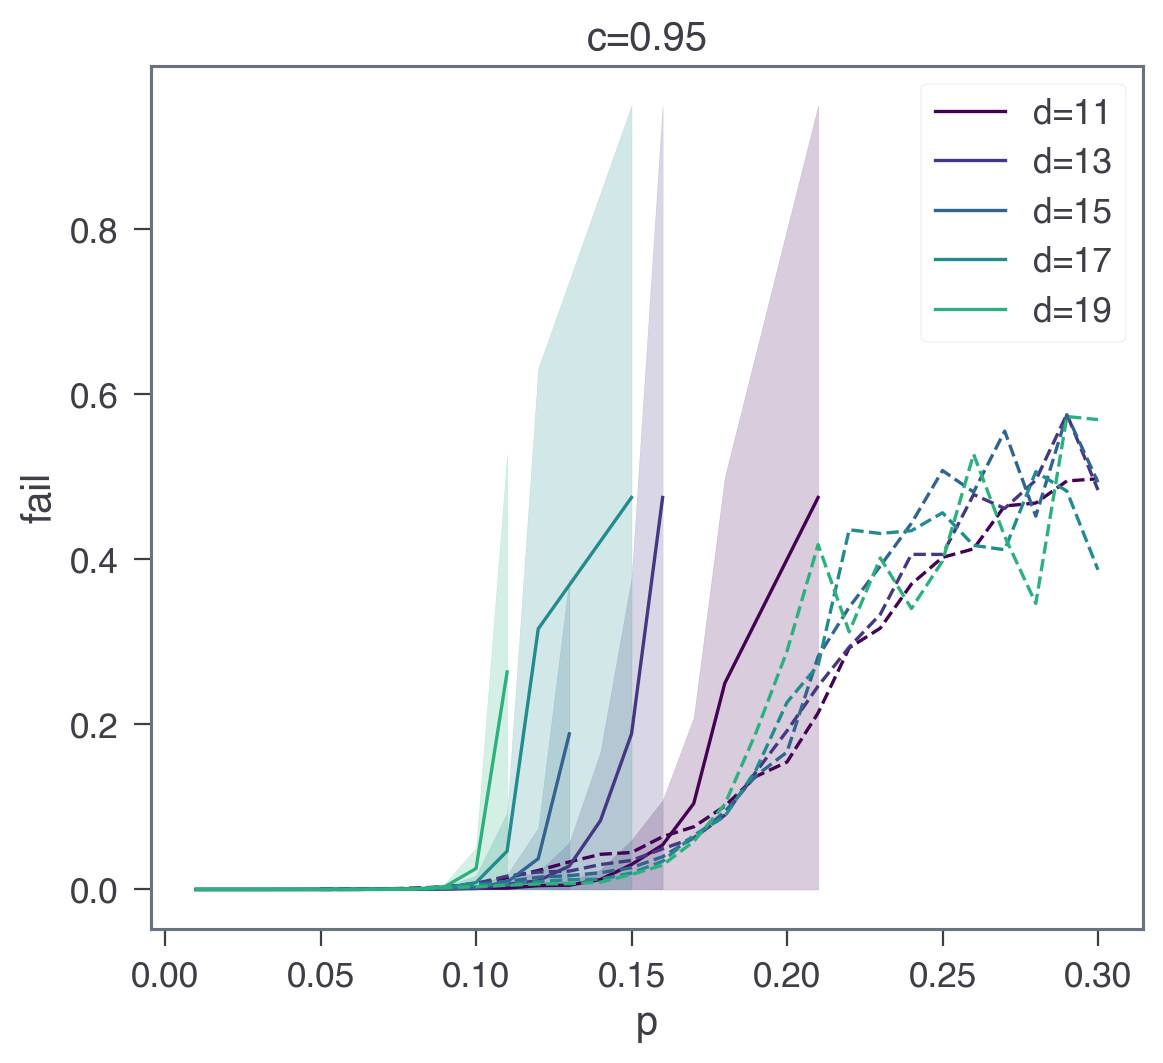

In [214]:
cmap = plt.cm.viridis
for c in np.arange(0.7, 0.99, 0.05).round(decimals=6):
    for i_d, d in enumerate(dlist):
        color = cmap(i_d/len(dlist)*0.8)
        df_partial = df_PS.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_partial, x='p', y='fail', color=color, label=r'd={}'.format(d))
        plt.fill_between(x=df_partial['p'], 
                         y1=df_partial['fail_low'],
                         y2=df_partial['fail_upp'],
                         color=color,
                         alpha=.2)
        df_PS_est_partial = df_PS_est.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_PS_est_partial, x='p', y='fail', color=color, linestyle='--')
    plt.legend()
    plt.title(r'c={}'.format(c))
    plt.show()

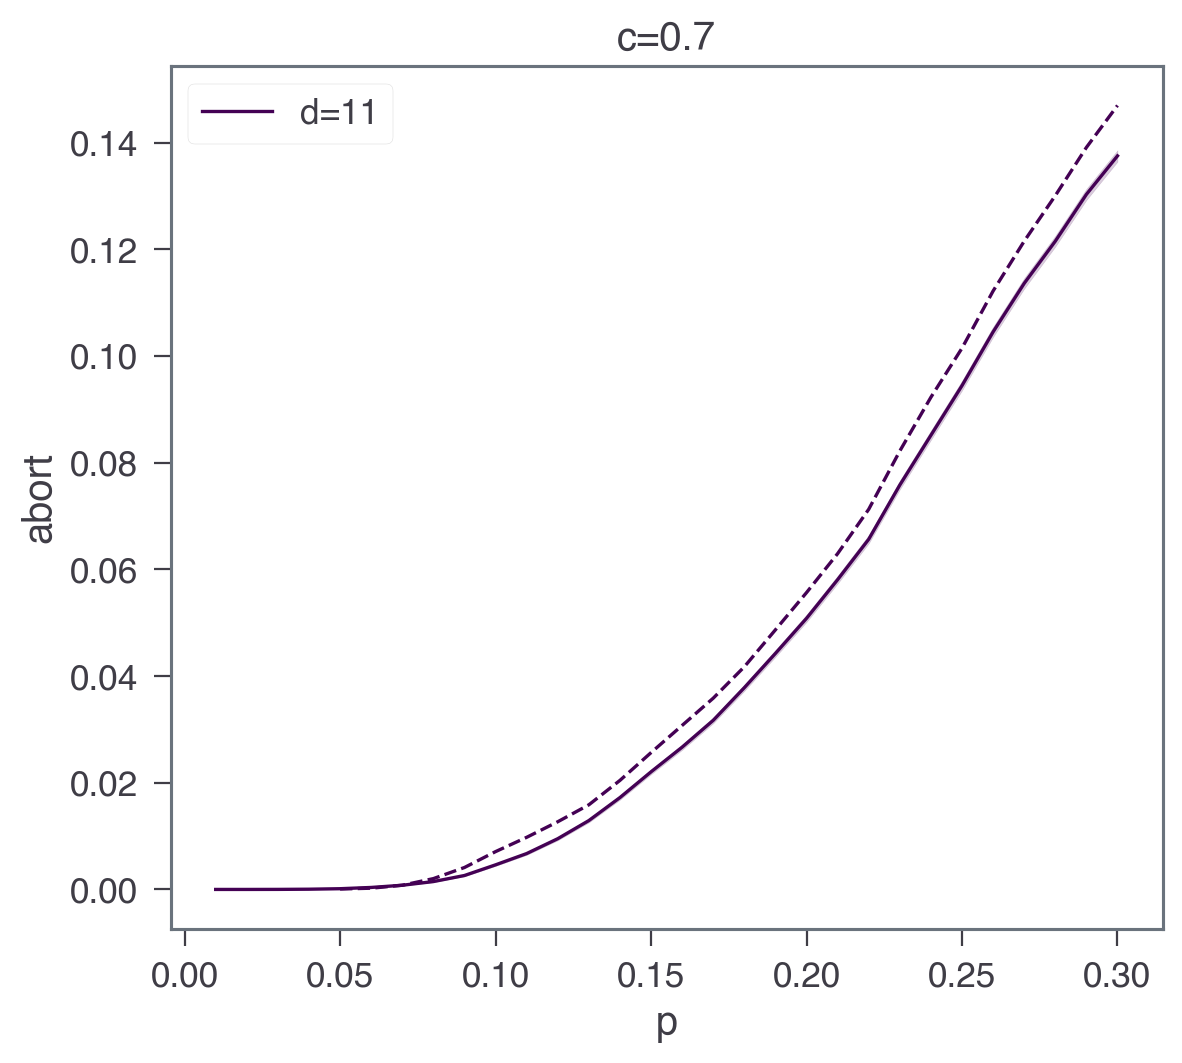

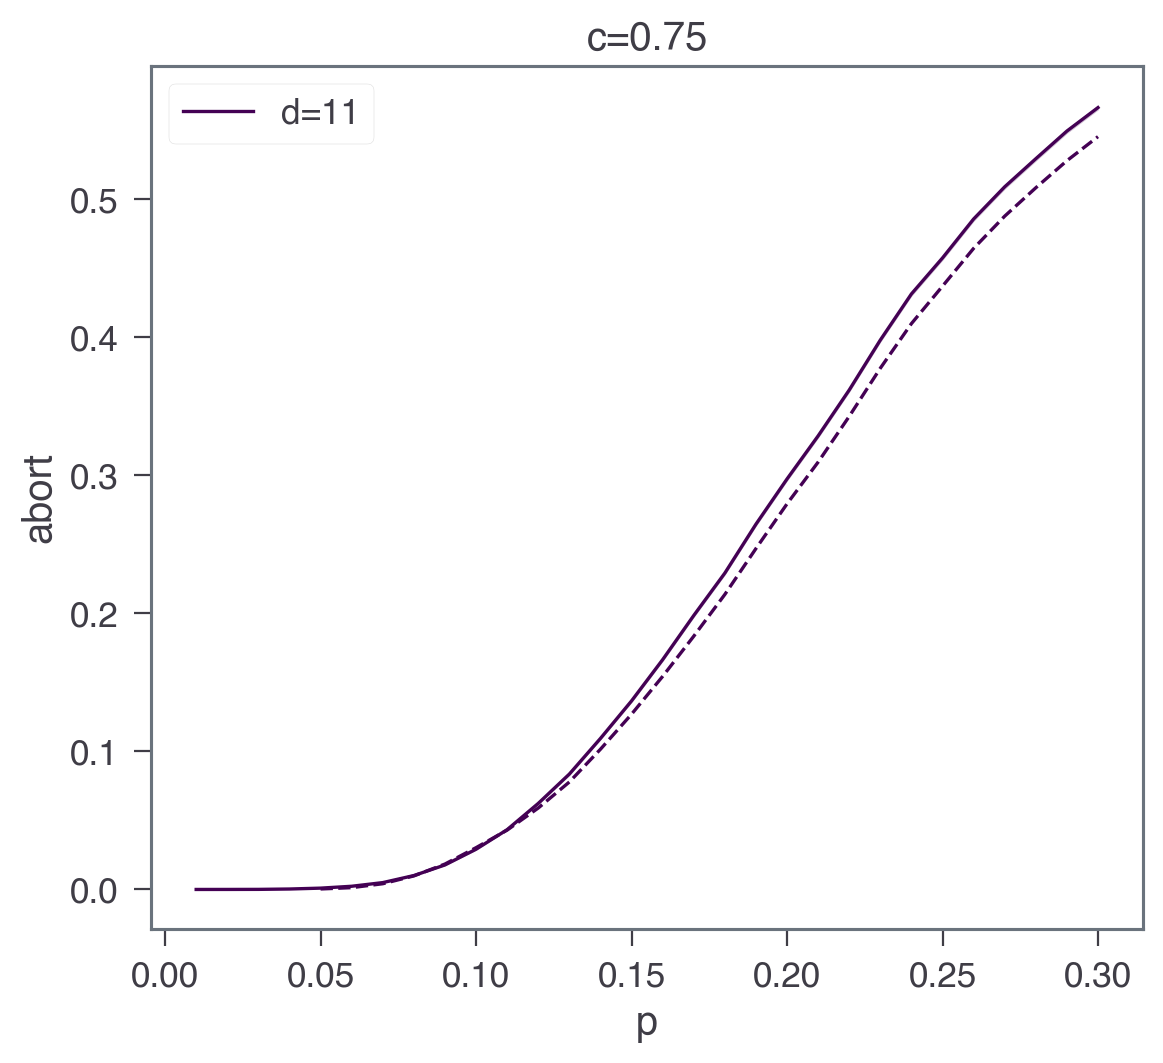

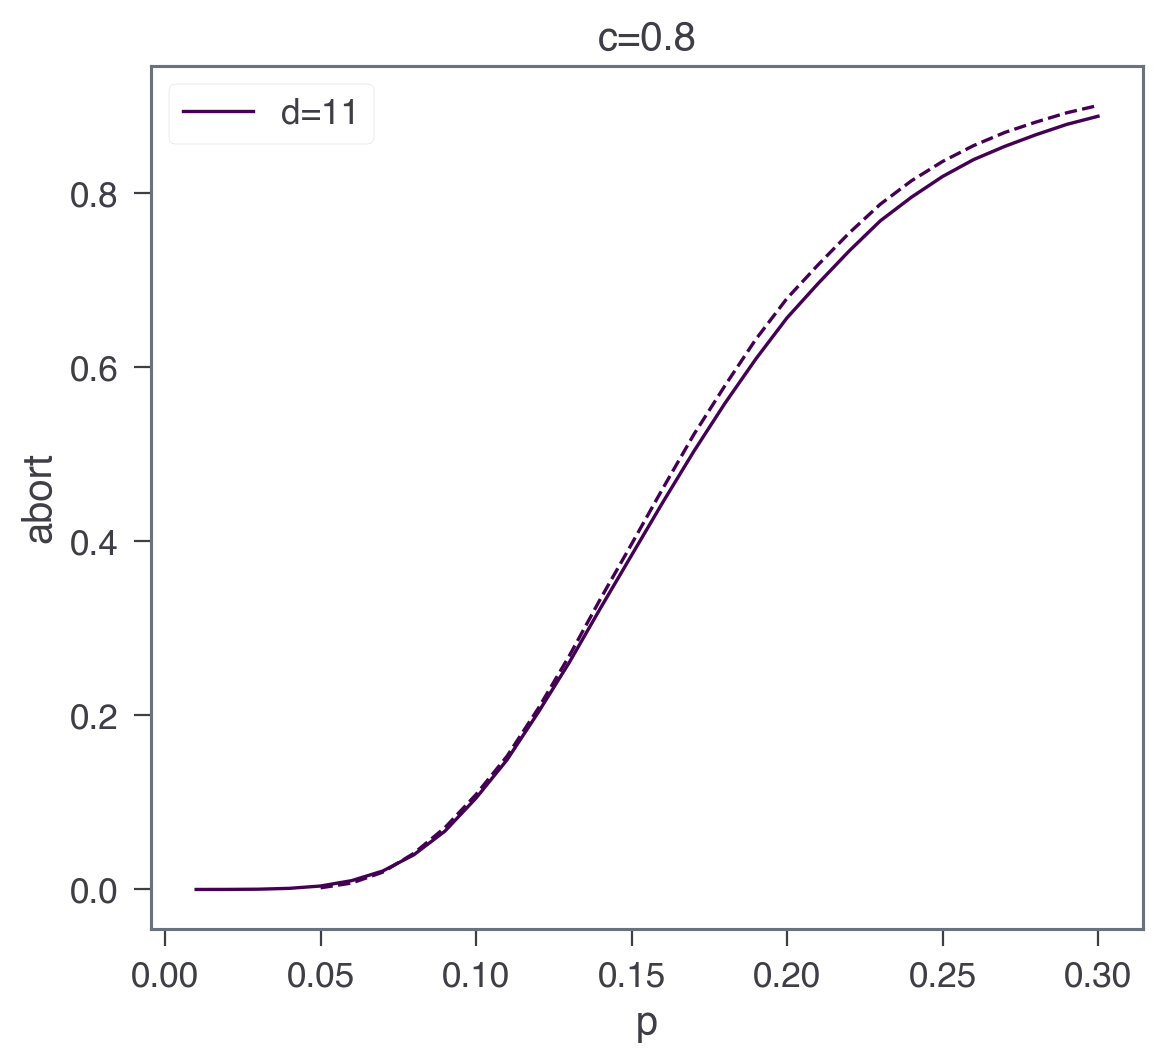

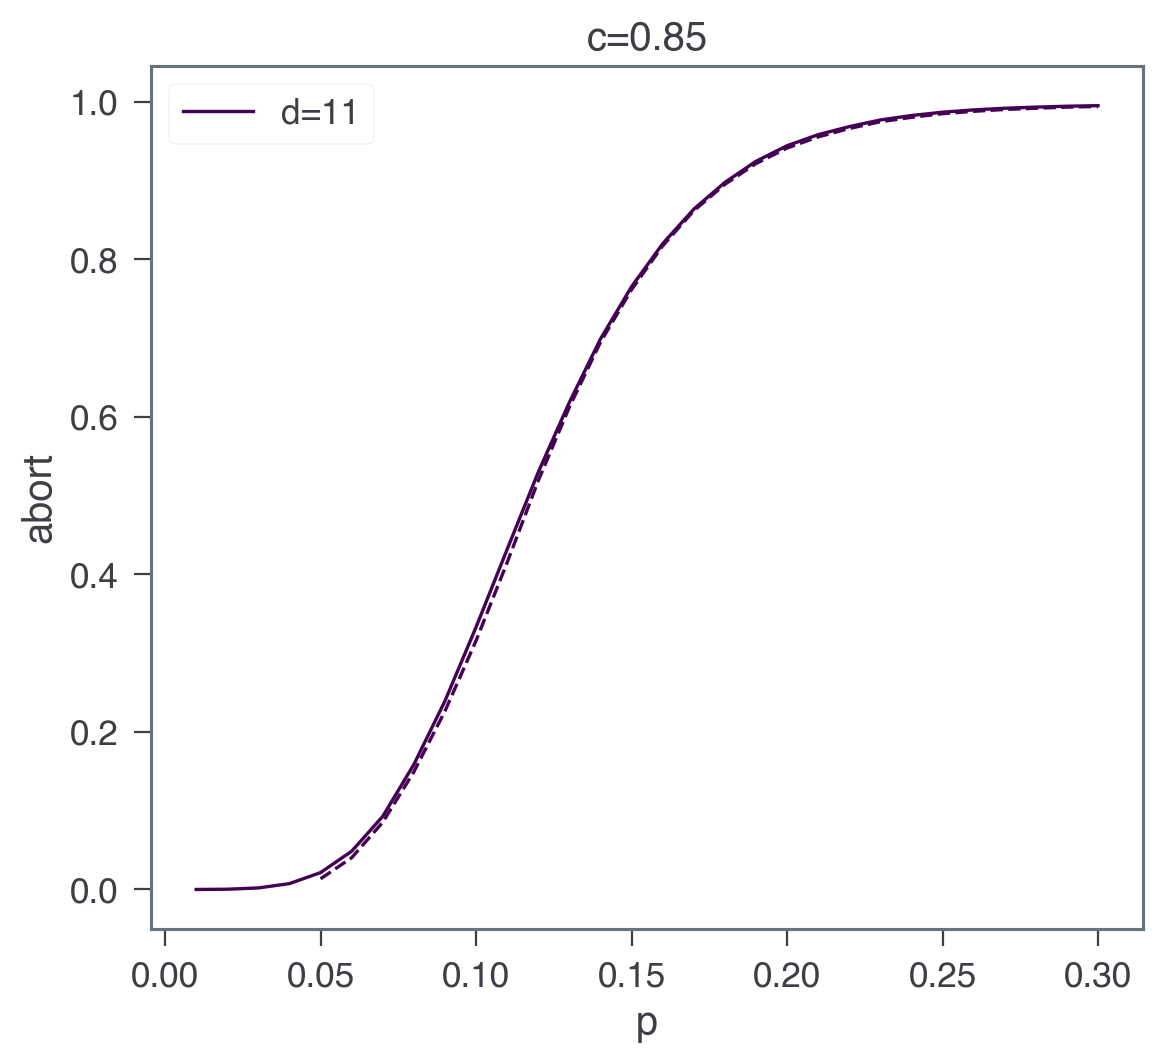

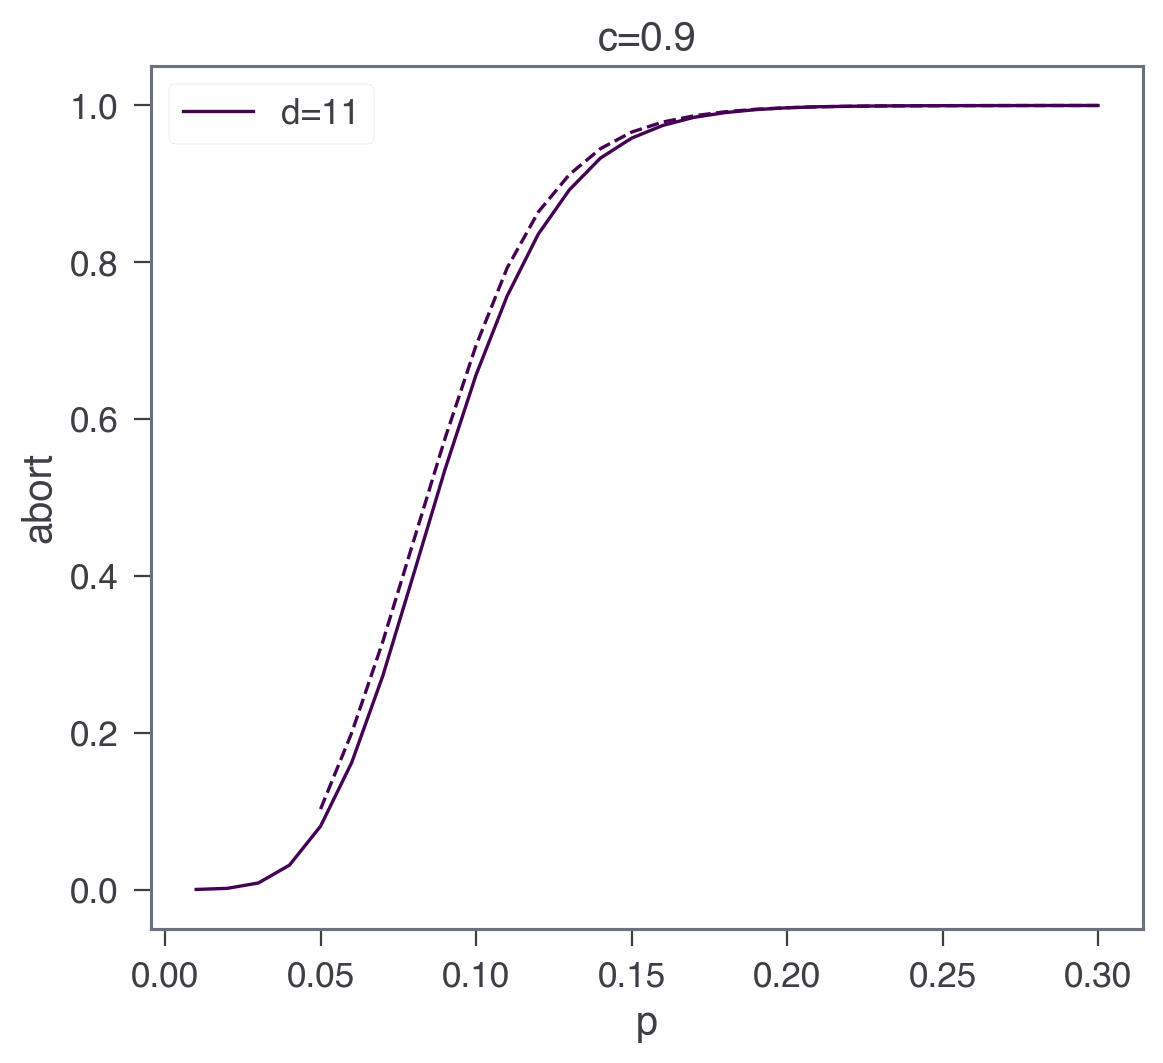

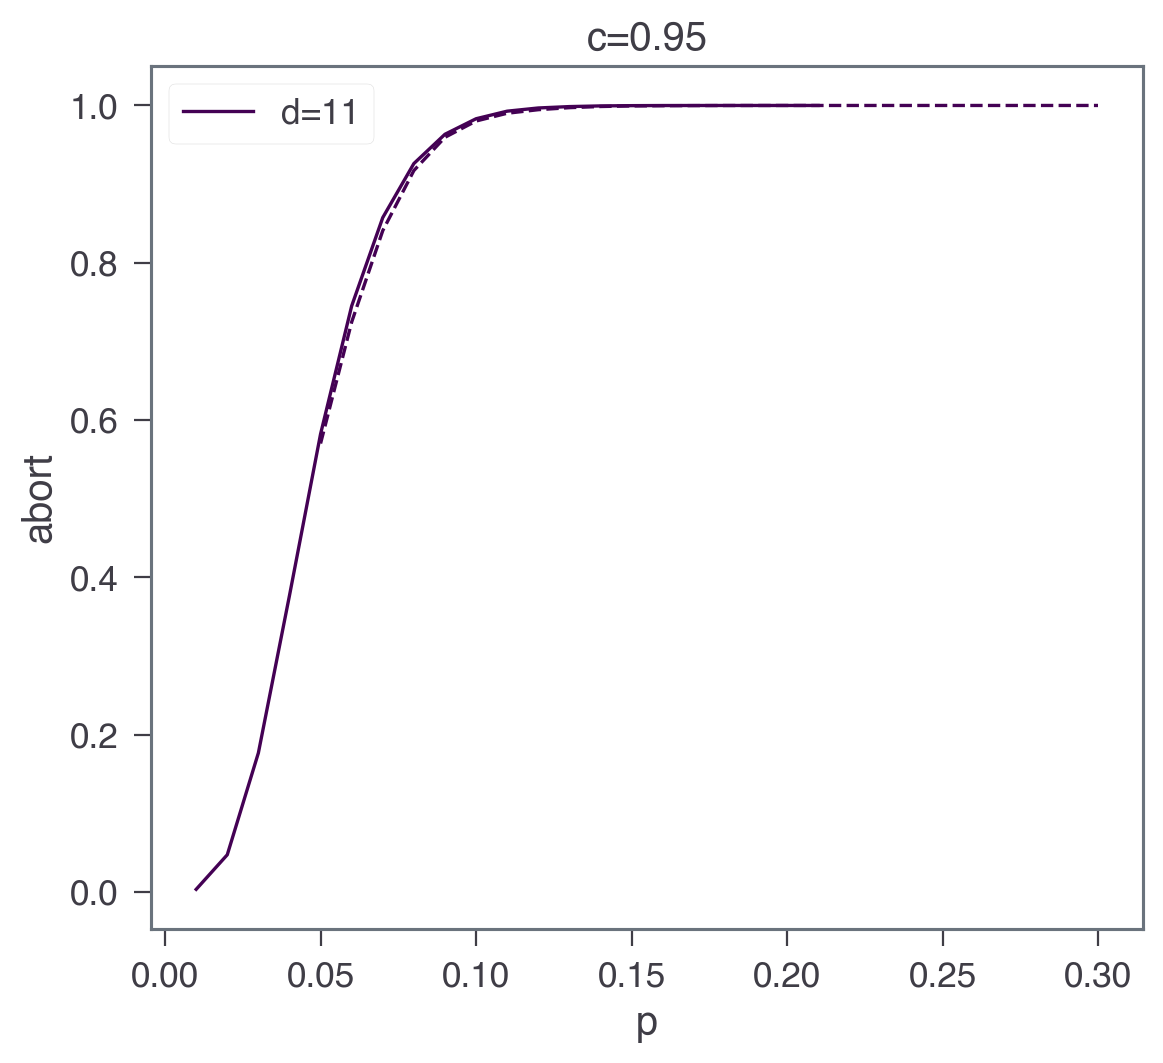

In [225]:
cmap = plt.cm.viridis
for c in np.arange(0.7, 0.99, 0.05).round(decimals=6):
    for i_d, d in enumerate(dlist):
        color = cmap(i_d/len(dlist)*0.8)
        df_partial = df_PS.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_partial, x='p', y='abort', color=color, label=r'd={}'.format(d))
        plt.fill_between(x=df_partial['p'], 
                         y1=df_partial['abort_low'],
                         y2=df_partial['abort_upp'],
                         color=color,
                         alpha=.2)
        df_PS_est_partial = df_PS_est.loc[idx[d, :, c], :].reset_index()
        sns.lineplot(df_PS_est_partial, x='p', y='abort', color=color, linestyle='--')
    plt.legend()
    plt.title(r'c={}'.format(c))
    plt.show()

In [ ]:
# We can calculate abort probabilities quite well. Can we somehow utilise them?